# DS210 - DeepLearning Sentiment Portfolio (DSP)
## Deep Learning Model
### Irene Na

## Set the environment

In [ ]:
!pip install --upgrade wrds --quiet
!pip install  --upgrade openpyxl -- quiet
!pip install yfinance --quiet
!pip install PyPortfolioOpt --quiet
!pip install cvxopt --quiet
!pip install cvxpy --quiet
!pip install openpyxl --quiet
!pip install tensorboard -- quiet
!pip install optuna --quiet
!pip install shap --quiet

import wrds
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import yfinance as yf
import importlib
# from statsmodels.regression.rolling import RollingOLS
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
from pypfopt import (
    EfficientFrontier,
    risk_models,
    plotting,
    # fix_nonpositive_semidefinite
)
import cvxpy as cp
import warnings
# warnings.filterwarnings("ignore")
warnings.filterwarnings('default')
from sklearn.covariance import LedoitWolf
from joblib import Parallel, delayed

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data import Subset
from datetime import datetime

import openpyxl
print(openpyxl.__version__)

from torch.utils.tensorboard import SummaryWriter
import optuna

import pdb
# pdb.set_trace() 
from torch.utils.data import ConcatDataset
import torch.multiprocessing as mp
import torch.distributed as dist
import s3fs
fs = s3fs.S3FileSystem()
import gc
import logging
import joblib
import shap

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
# display(cp.installed_solvers())

In [ ]:
# import other modules
import ds210_ml_portf_data_retrieval as data_unit

## Reference:
- https://github.com/aws-samples/amazon-sagemaker-immersion-day/blob/master/bring-your-own-model/bring-custom-script-pytorch.ipynb
- https://github.com/caopuzheng/capstone-2024-summer/blob/master/src/ray/Embedding-memory-saver.ipynb
- https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html
- https://pytorch.org/tutorials/intermediate/ddp_tutorial.html

## Utile Functions

In [ ]:
def regression_sm(df_y, df_x):
    idx1 = df_x.dropna(how='all').index
    idx2 = df_y.dropna(how='all').index

    index_comm = idx1.intersection(idx2, sort=False)
    df_Y = df_y.reindex(index_comm)
    df_X = df_x.reindex(index_comm)

    x, y = df_X, df_Y
    x = sm.add_constant(x, has_constant='add')
    model_prefit = sm.OLS(y,x)
    sm_model = model_prefit.fit()
    param_reg = sm_model.params
    return x, y, sm_model, model_prefit, param_reg

def optimizer_ef(ann_exp_exc_rtn, ann_cov_matrix, opt_flag, target_risk,
                 solver_name='CLARABEL', market_neutral=False, risk_free_rate=None):
    ef_ob = EfficientFrontier(ann_exp_exc_rtn, ann_cov_matrix)
    ef_ob._solver = solver_name # IN: 'CLARABEL', this solver works for max_sharpe choice, and likely better for 'target_risk' too
    # ef_ob._solver_options ={'ECOS':cp.ECOS}
    # ef_ob._solver = 'ECOS'

    if opt_flag == 'target_risk':
        ef_ob.efficient_risk(target_volatility=target_risk, market_neutral=market_neutral)
    elif opt_flag == 'max_sharpe':
        if risk_free_rate:
            # print ('here')
            # ef_ob.risk_free_rate = risk_free_rate # set risk free rate as zero; default: 0.02 in def max_sharpe(self, risk_free_rate=0.02)
            ef_ob.max_sharpe(risk_free_rate = risk_free_rate)
        else:
            ef_ob.max_sharpe()

    return ef_ob.clean_weights()

def prep_rank_feature(df, features_col, shift_d):

    rank_features_col_lag = [x+'_rank' for x in features_col]
    rank_feat = df.set_index(['date','permno'])[features_col].groupby('date')\
        .apply(lambda x: (x.rank(pct=True)-0.5).droplevel(0))\
            .rename(columns=dict(zip(features_col, rank_features_col_lag))).reset_index()
    # regroup by stock and do the shift
    rank_feat = rank_feat.set_index('date').groupby('permno')[rank_features_col_lag]\
        .apply(lambda x: x.shift(shift_d)).reset_index()

    df = pd.merge(df, rank_feat, on=['date','permno'], how='left')

    return df, rank_features_col_lag

def mmd_cal(df, return_col_name):
    df_0 = df.copy()
    df_0['cum_rtn']=(1+df_0[return_col_name]).cumprod()
    df_0['drawdown'] = (df_0['cum_rtn']-df_0['cum_rtn'].cummax())/df_0['cum_rtn'].cummax()
    df_0['max_drawdown'] =  df_0['drawdown'].cummin()
    return df_0['max_drawdown']

def portfolio_performance(input_df, weight_df, portf_name, rebal_freq, mkt_df, 
                          last_win_only=False, vol_scaler_flag=False, scaling_vol_tgt=0.3, plot_show=True): #IN mod
    # rebal_freq: 'D','M','W'
    if rebal_freq =='D':
        ff_n = 2
    elif rebal_freq == 'W':
        ff_n = 7
    elif rebal_freq == 'M':
        ff_n = 31
        
    if last_win_only is True: #IN mod, if it's last_win_only mode (demo mode), only use last year data, and backfill the weights 
       return_df = input_df[input_df['date'].dt.year.isin([2024])].set_index(['date','permno'])['return'].unstack()[weight_df.columns]
       weight_df=weight_df.asfreq('D').ffill(limit=ff_n).reindex(return_df.index)\
        .ffill().bfill().where(~(return_df.isnull()), 0)
       mkt_df = mkt_df.loc[return_df.index,:]
    else: 
        return_df = input_df.set_index(['date','permno'])['return'].unstack()[weight_df.columns]
        weight_df=weight_df.asfreq('D').ffill(limit=ff_n).reindex(return_df.index).where(~(return_df.isnull()), 0)
    portf_rtn = (return_df*weight_df).sum(axis=1)

    if vol_scaler_flag is True:
        # print ('here')
        portf_rtn_0 = portf_rtn.copy()
        if (last_win_only is True) or (portf_rtn.index[0]>=datetime.strptime('2021-01-01', '%Y-%m-%d')): #IN mod5
            # portf_rtn = (portf_rtn_0*(scaling_vol_tgt/np.sqrt(252))/(portf_rtn_0.rolling(60, min_periods=2).std())).fillna(0) #IN mod2
            portf_rtn = (portf_rtn_0*(scaling_vol_tgt/np.sqrt(252))/(portf_rtn_0.rolling(60, min_periods=20).std())) #IN mod4
        else: 
            portf_rtn = portf_rtn_0*(scaling_vol_tgt/np.sqrt(252))/(portf_rtn_0.rolling(60).std())
        scaler_df = portf_rtn.div(portf_rtn_0, axis=0)
        # scaled_mkt = mkt_df['return_sp']*scaling_vol_tgt/mkt_df['return_sp'].rolling(60).std()
        unscaled_mkt = mkt_df['return_sp'].loc[portf_rtn.index[0]:]
        # print(unscaled_mkt)
    else:
        # print ('there')
        scaler_df = portf_rtn.div(portf_rtn, axis=0)
        # scaled_mkt = mkt_df['return_sp']*(portf_rtn.rolling(60).std()/mkt_df['return_sp'].rolling(60).std())
        unscaled_mkt = mkt_df['return_sp'].loc[portf_rtn.index[0]:]
    
    fig1, ax1 = plt.subplots(1,2, figsize=(11,3.5))
    portf_mkt_rtn = pd.concat([portf_rtn.rename(portf_name), unscaled_mkt.rename('Unscaled Market')], axis=1)
    portf_mkt_rtn.cumsum().plot(ax=ax1[0])
    ax1[0].set_title(f'Cumulative Return Comparison')
    ax1[0].legend(loc='upper left')
    # plt.legend()
    # plt.show()
    ax1[0].set_ylabel('Cumulative Return') #IN mod3

    if last_win_only is True:
        (portf_mkt_rtn.rolling(60).std()*np.sqrt(252)).plot(
            ax=ax1[1],
            title='Rolling Annual Vol Comparison')
        ax1[1].legend(loc='upper left')
    else:
        (portf_mkt_rtn.rolling(252).std()*np.sqrt(252)).plot(
        ax=ax1[1],
        title='Rolling Annual Vol Comparison')
        ax1[1].legend(loc='upper left')
        
    ax1[1].set_ylabel('Rolling Annual Vol') #IN mod3
    
    fig1.suptitle(f'{portf_name} vs (Unscaled) S&P500 Cumulative Return and Rolling Vol Comparison')
    plt.subplots_adjust(top=0.85, bottom=0.01, wspace=0.2)
    if plot_show is True: #IN mod
        plt.show()
    plt.close()

    stats_df = pd.DataFrame(columns=portf_mkt_rtn.columns)
    stats_df.loc['avg_rtn_ann',:] = portf_mkt_rtn.mean()*252
    stats_df.loc['vol_ann',:] = portf_mkt_rtn.std()*np.sqrt(252)
    stats_df.loc['sharpe_ann',:] = stats_df.loc['avg_rtn_ann',:]/stats_df.loc['vol_ann',:]
    stats_df.loc['max_drawdown',portf_name] = mmd_cal(portf_mkt_rtn, portf_name).iloc[-1]
    stats_df.loc['max_drawdown','Unscaled Market'] = mmd_cal(portf_mkt_rtn, 'Unscaled Market').iloc[-1]
    
    if plot_show is True: #IN mod
        print(stats_df)    

    return portf_rtn, portf_mkt_rtn, stats_df, scaler_df, fig1

def performance_comparison_all(portf_rtn_df_l, mkt_rtn, stats_df_l, \
                               rebal_freq, last_win_only=False, plot_show=True):
    # by the process the portf series should already have unique names except unscaled mkt
    portf_mkt_rtn_comb = pd.concat(portf_rtn_df_l + [mkt_rtn], axis=1)
    stats_df_comb = pd.concat(stats_df_l, axis=1).T.drop_duplicates().sort_values(by='sharpe_ann', ascending=False).T     
    #this way we drop duplicated cols, given drop_duplicates() is designed for rows

    fig1, ax1 = plt.subplots(1,2, figsize=(11,3.5))
    
    # portf_mkt_rtn = pd.concat([portf_rtn.rename(portf_name), unscaled_mkt.rename('Unscaled Market')], axis=1)
    portf_mkt_rtn_comb.cumsum().plot(ax=ax1[0])
    ax1[0].set_title(f'Cumulative Return Comparison')
    ax1[0].legend(loc='upper left')
    ax1[0].set_ylabel('Cumulative Return') #IN mod3
    
    if last_win_only is True:
        (portf_mkt_rtn_comb.rolling(60).std()*np.sqrt(252)).plot(
            ax=ax1[1],
            title='Rolling Annual Vol Comparison')
        ax1[1].legend(bbox_to_anchor=(1,1))
    else:
        (portf_mkt_rtn_comb.rolling(252).std()*np.sqrt(252)).plot(
        ax=ax1[1],
        title='Rolling Annual Vol Comparison')
        ax1[1].legend(bbox_to_anchor=(1,1))
    ax1[1].set_ylabel('Rolling Annual Vol') #IN mod3
    
    if len(portf_mkt_rtn_comb.loc['2021-01-01':,:])>0 and last_win_only is False: 
        ax1[0].axvline(x='2020-12-31', color='red', linestyle='--', linewidth=1.5, label='Train vs Test Division')
        ax1[1].axvline(x='2020-12-31', color='red', linestyle='--', linewidth=1.5, label='Train vs Test Division')
        ax1[0].legend(loc='upper left')
        ax1[1].legend(bbox_to_anchor=(1,1))
    
    fig1.suptitle(f'Proposed Portforlio ({rebal_freq}) vs (Unscaled) S&P500 Cumulative Return and Rolling Vol Comparison')
    plt.subplots_adjust(top=0.85, bottom=0.01, wspace=0.2)
    if plot_show is True: #IN mod
        plt.show()
    plt.close()
    
    if plot_show is True: #IN mod
        print(stats_df_comb)    

    return portf_mkt_rtn_comb, stats_df_comb, fig1
    
def performance_comparison_all_recal(portf_rtn_df_l, mkt_rtn,\
                               rebal_freq, last_win_only=False, plot_show=True):
    # by the process the portf series should already have unique names except unscaled mkt
    portf_mkt_rtn_comb = pd.concat(portf_rtn_df_l + [mkt_rtn], axis=1)

    fig1, ax1 = plt.subplots(1,2, figsize=(11,3.5))
    
    # portf_mkt_rtn = pd.concat([portf_rtn.rename(portf_name), unscaled_mkt.rename('Unscaled Market')], axis=1)
    portf_mkt_rtn_comb.cumsum().plot(ax=ax1[0])
    ax1[0].set_title(f'Cumulative Return Comparison')
    ax1[0].legend(loc='upper left')
    ax1[0].set_ylabel('Cumulative Return') #IN mod3

    # if last_win_only is True:
    if portf_mkt_rtn_comb.index[0]>=datetime.strptime('2021-01-01', '%Y-%m-%d'):
        (portf_mkt_rtn_comb.rolling(60).std()*np.sqrt(252)).plot(
            ax=ax1[1],
            title='Rolling Annual Vol Comparison')
        ax1[1].legend(bbox_to_anchor=(1,1))
    else:
        (portf_mkt_rtn_comb.rolling(252).std()*np.sqrt(252)).plot(
        ax=ax1[1],
        title='Rolling Annual Vol Comparison')
        ax1[1].legend(bbox_to_anchor=(1,1))
    ax1[1].set_ylabel('Rolling Annual Vol') #IN mod3

    if (len(portf_mkt_rtn_comb.loc['2021-01-01':,:])>0) and last_win_only is False: 
        ax1[0].axvline(x='2020-12-31', color='red', linestyle='--', linewidth=1.5, label='Train vs Test Division')
        ax1[1].axvline(x='2020-12-31', color='red', linestyle='--', linewidth=1.5, label='Train vs Test Division')
        ax1[0].legend(loc='upper left')
        ax1[1].legend(bbox_to_anchor=(1,1))
        
    fig1.suptitle(f'Proposed Portforlio ({rebal_freq}) vs (Unscaled) S&P500 Cumulative Return and Rolling Vol Comparison')
    plt.subplots_adjust(top=0.85, bottom=0.01, wspace=0.2)
    if plot_show is True: #IN mod
        plt.show()
    plt.close()

    # recalculate stats table
    stats_df_comb = pd.DataFrame(columns=portf_mkt_rtn_comb.columns)
    stats_df_comb.loc['avg_rtn_ann',:] = portf_mkt_rtn_comb.mean()*252
    stats_df_comb.loc['vol_ann',:] = portf_mkt_rtn_comb.std()*np.sqrt(252)
    stats_df_comb.loc['sharpe_ann',:] = stats_df_comb.loc['avg_rtn_ann',:]/stats_df_comb.loc['vol_ann',:]

    for col in portf_mkt_rtn_comb.columns:
        stats_df_comb.loc['max_drawdown',col] = mmd_cal(portf_mkt_rtn_comb, col).iloc[-1]

    # stats_df_comb = stats_df_comb.T.sort_values(by='sharpe_ann', ascending=False).T
    
    if plot_show is True:
        print(stats_df_comb)
    
    return portf_mkt_rtn_comb, stats_df_comb, fig1
    
def check_weights_plots(opt_weight_df):
    # check basic properties for optimization weights:
    np.round(opt_weight_df.sum(axis=1),2).plot(title='Total weights for the portfolio over time', figsize=(5,3))
    plt.show()

    opt_weight_df.count(axis=1).plot(title='Total number of stocks over time (not all have non zero weight)', figsize=(5,3))
    plt.show()

    opt_weight_df[opt_weight_df>0].count(axis=1).plot(title='Total number of stocks with non-zero weight over time', figsize=(5,3))
    plt.show()


## Prepare Data

### Get DL Model Data

In [ ]:
# Get data
# data_directory = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN/data-used'
# data_directory = r'/content/drive/MyDrive/Datasci-210/data-used/' ## for colab
data_directory = r'/home/sagemaker-user/user-default-efs/data-used/' ## for sm

data_checkpoint_name = 'data_checkpoint4'  # 'data_checkpoint1'
start_date = '2000-01-01'
train_end_date = '2020-12-31'

data_obj = data_unit.data_main(data_directory, data_checkpoint_name, start_date, train_end_date, verbose=False)

# Get data from the object
sp500_used = data_obj.data_dic['sp500_used']
train_val_sp500 = data_obj.data_dic['train_sp500']
test_sp500 = data_obj.data_dic['test_sp500']
train_val_mkt = data_obj.data_dic['train_mkt']
test_mkt = data_obj.data_dic['test_mkt']
data_useful_info_dic = data_obj.data_dic['data_useful_info_dic']

display(data_useful_info_dic.keys())

# ticker- permno map (this step is moved to data level)
# multi_index = train_sp500.set_index(['ticker','permno']).index.unique()
# ticker_permno_dic = {item[0]:item[1] for item in multi_index}
# permno_ticker_dic = {item[1]:item[0] for item in multi_index}


The checkpoint name of this data is , 
and data_dic keys are []

The checkpoint name of this data is data_checkpoint4, 
and data_dic keys are ['data_useful_info_dic', 'sp500_used', 'mkt_daily', 'train_sp500', 'test_sp500', 'train_mkt', 'test_mkt', 'ticker_permno_dic', 'permno_ticker_dic']


dict_keys(['useful_columns_raw', 'name_map', 'time_columns', 'identifier_columns', 'categorical_columns', 'numerical_columns'])

### Get sentiment output data:

In [ ]:
# Get sentiment data:
path_to_sentiment_data = r'/home/sagemaker-user/user-default-efs/data-used/' ## for sm
senti_file_name = 'Sentiment_Predictions_w_Imputed_Values.parquet'
senti_df = pd.read_parquet(f'{path_to_sentiment_data}/{senti_file_name}')
display(senti_df.columns) 
display(senti_df.shape)

Index(['Date', 'return_sp_lag', 'Negative_Prob', 'Neutral_Prob',
       'Positive_Prob', 'predicted_binary_return',
       'predicted_continuous_return', 'Month', 'Year'],
      dtype='object')

(6037, 9)

In [ ]:
train_val_senti = senti_df[senti_df['Date']<=train_end_date].set_index('Date')\
                            [['predicted_continuous_return','Negative_Prob','Neutral_Prob','Positive_Prob','predicted_binary_return']]
test_senti = senti_df[senti_df['Date']>train_end_date].set_index('Date')\
                        [['predicted_continuous_return','Negative_Prob','Neutral_Prob','Positive_Prob','predicted_binary_return']]

### Build features

In [ ]:
def feature_engineer_dl(input_raw, mkt_input_raw, ticker_list, check_visual=False, senti_used=None):
        print ('Start feature engineering..')
        # prepare features
        # sel_features = ['market_equity','book_to_equity','asset_growth','opt_to_book_eq','ret_12m_d']
        sel_features = ['market_equity','book_to_equity','asset_growth','opt_to_book_eq','ret_12m_d', 'ret_3m_d', 'ret_6m_d',\
                        'ret_1m_d', 'ret_60_12']
        sel_tgt = ['return']

        # prepare model used data
        input_used = input_raw[['date','permno','ticker']+sel_features+sel_tgt]

        if len(ticker_list)!=0:
            input_used = input_used[input_used['ticker'].isin(ticker_list)]

        # further adjustment on return based feature by filling the first year data with ret_12_1 (monthly)
        ret_feat_map = {'ret_12m_d':'ret_12_1', 'ret_6m_d':'ret_6_1', 'ret_3m_d':'ret_3_1', 'ret_1m_d':'ret_1_0'}
        for col in ['ret_12m_d', 'ret_1m_d', 'ret_3m_d', 'ret_6m_d']:
            if col in sel_features:
                input_used.loc[input_used['date']<'2000-12-29', col] = \
                    input_used.loc[input_used['date']<'2000-12-29', col]\
                        .fillna(input_raw.loc[input_raw['date']<'2000-12-29', ret_feat_map[col]])

        # prepare a column called previous period excess return for factor return regression later
        # add mkt return to the data
        print (f'The shape of input_used before adding return_sp and excess return is {input_used.shape}')
        input_used = pd.merge(input_used, mkt_input_raw.reset_index()[['Date','return_sp']].rename(columns={'Date':'date'}),
                            on=['date'], how='left')
        input_used['excess_ret'] = input_used['return']-input_used['return_sp']
        print (f'The shape of input_used after adding return_sp and excess return is {input_used.shape}')

        prev_d_exc_ret_df = input_used.set_index('date').groupby('permno')['excess_ret']\
            .apply(lambda x: x.shift()).rename('prev_d_exc_ret').reset_index()

        # prepare a column called previuos market return for later use (new to dl model)
        prev_d_mkt_ret_df = input_used.set_index('date').groupby('permno')['return_sp']\
            .apply(lambda x: x.shift()).rename('prev_d_mkt_ret').reset_index()

        # add future return and magnitude parameter for additional target
        next_5d_ret_df = input_used.set_index('date').groupby('permno')['return']\
            .apply(lambda x: x.rolling(5).sum().shift(-4)).rename('next_5d_ret').reset_index()
        # IN: this means today's return + next 4 days return

        next_5d_abs_ret_df = input_used.set_index('date').groupby('permno')['return']\
            .apply(lambda x: x.rolling(5).sum().shift(-4).abs()).rename('next_5d_abs_ret').reset_index()

        abs_ret_df = input_used.set_index('date').groupby('permno')['return']\
            .apply(lambda x: x.abs()).rename('abs_ret').reset_index()

        # create vol related inputs (both excess return and mkt return vol)
        # exc_ret_vol_20d = input_used.set_index('date').groupby('permno')['excess_ret']\
        #     .apply(lambda x: x.rolling(20, min_periods=1).std()).rename('exc_ret_vol_20d').reset_index()

        ret_vol_20d = input_used.set_index('date').groupby('permno')['return']\
            .apply(lambda x: x.rolling(20, min_periods=1).std()).rename('ret_vol_20d').reset_index()
    
        mkt_ret_vol_20d = input_used.set_index('date').groupby('permno')['return_sp']\
            .apply(lambda x: x.rolling(20, min_periods=1).std()).rename('mkt_ret_vol_20d').reset_index()

        # prev_d_exc_ret_vol_20d = exc_ret_vol_20d.set_index('date').groupby('permno')['exc_ret_vol_20d']\
        #     .apply(lambda x: x.shift()).rename('prev_d_exc_ret_vol_20d').reset_index()

        prev_d_ret_vol_20d = ret_vol_20d.set_index('date').groupby('permno')['ret_vol_20d']\
            .apply(lambda x: x.shift()).rename('prev_d_ret_vol_20d').reset_index()

        prev_d_mkt_ret_vol_20d = mkt_ret_vol_20d.set_index('date').groupby('permno')['mkt_ret_vol_20d']\
            .apply(lambda x: x.shift()).rename('prev_d_mkt_ret_vol_20d').reset_index()

        print (f'The shape of input_used before adding next n day return, abs return ect. is {input_used.shape}')
        input_used = pd.merge(input_used, next_5d_ret_df, on=['date','permno'], how='left')
        input_used = pd.merge(input_used, next_5d_abs_ret_df, on=['date','permno'], how='left')
        input_used = pd.merge(input_used, abs_ret_df, on=['date','permno'], how='left')
        print (f'The shape of input_used after adding next n day return, abs return ect. is {input_used.shape}')

        print (f'The shape of input_used before adding prev_d_exc_ret is {input_used.shape}')
        input_used = pd.merge(input_used, prev_d_exc_ret_df, on=['date','permno'], how='left')
        print (f'The shape of input_used after adding prev_d_exc_ret is {input_used.shape}')

        # add pre_d mkt return new to dl model
        print (f'The shape of input_used before adding prev_d_mkt_ret is {input_used.shape}')
        input_used = pd.merge(input_used, prev_d_mkt_ret_df, on=['date','permno'], how='left')
        print (f'The shape of input_used after adding prev_d_mkt_ret is {input_used.shape}')

        # add vol related metrics dl model
        print (f'The shape of input_used before adding vol related metrics is {input_used.shape}')
        # input_used = pd.merge(input_used, exc_ret_vol_20d, on=['date','permno'], how='left')
        input_used = pd.merge(input_used, ret_vol_20d, on=['date','permno'], how='left')
        input_used = pd.merge(input_used, mkt_ret_vol_20d, on=['date','permno'], how='left')
        # input_used = pd.merge(input_used, prev_d_exc_ret_vol_20d, on=['date','permno'], how='left')
        input_used = pd.merge(input_used, prev_d_ret_vol_20d, on=['date','permno'], how='left')
        input_used = pd.merge(input_used, prev_d_mkt_ret_vol_20d, on=['date','permno'], how='left')
        print (f'The shape of input_used after adding vol related metrics is {input_used.shape}')
    
        # add rank_features, with shift
        print (f'The shape of input_used before adding rank_features is {input_used.shape}')
        input_used, sel_features_adj = prep_rank_feature(input_used, sel_features, shift_d=1)
        print (f'The shape of input_used after adding rank_features is {input_used.shape}')

        # min_max scale the pred_d_log items for prediction
        scaler = MinMaxScaler()
        cols_to_scale = ['prev_d_exc_ret', 'prev_d_mkt_ret', 'prev_d_ret_vol_20d', 'prev_d_mkt_ret_vol_20d']
        cols_scaled = [f'scaled_{col}' for col in cols_to_scale]
        scaled_pred_d_rets = scaler.fit_transform(input_used[cols_to_scale])
        scaled_pred_d_rets_df = pd.DataFrame(scaled_pred_d_rets,
                                             index = input_used.index,
                                             columns=cols_scaled)
        # add scaled columns (new to dl) 
        print (f'The shape of input_used before adding scaled pre_d rets_features is {input_used.shape}')
        input_used = pd.concat([input_used, scaled_pred_d_rets_df], axis=1)
        print (f'The shape of input_used after adding pre_d rets_features is {input_used.shape}')
            
        # add prev_d exc ret and pred_d mkt return to sel_features_adj new to dl model
        sel_features_adj.extend(cols_scaled)
        
        if type(senti_used) == pd.core.frame.DataFrame:
            print (f'The shape of input_used before adding scaled sentiment scores is {input_used.shape}')
            input_used = pd.merge(input_used, senti_used.reset_index()[['Date','predicted_continuous_return']]\
                                  .rename(columns={'Date':'date','predicted_continuous_return':'senti_score'}),
                                on=['date'], how='left')
            input_used['scaled_senti_score'] = MinMaxScaler().fit_transform(input_used['senti_score'].to_frame())
            print (f'The shape of input_used after adding scaled sentiment scores is {input_used.shape}')
            sel_features_adj.append('scaled_senti_score')

        print (f'\nThe added columns are: {sel_features_adj}')
    
        if check_visual:
            # Check the distribution of the ranked and shifted signals
            n = len(sel_features_adj)
            n_per_row=3
            if n%n_per_row==0:
                n_rows = n//n_per_row
            else:
                n_rows = n//n_per_row+1
            fig1, ax1 = plt.subplots(n_rows, n_per_row, figsize=(12,6))
            for i, col in enumerate(sel_features_adj):
                input_used[col].to_frame().hist(ax=ax1[i//n_per_row, i%n_per_row])
                ax1[i//n_per_row, i%n_per_row].set_title(f'Histogram of {col}')
            plt.suptitle('Check the distribution of ranked features')
            plt.subplots_adjust(hspace=0.9)
            plt.show()

        return input_used, sel_features_adj

Processing training data (train_val actually)..
Start feature engineering..
The shape of input_used before adding return_sp and excess return is (2641874, 13)
The shape of input_used after adding return_sp and excess return is (2641874, 15)
The shape of input_used before adding next n day return, abs return ect. is (2641874, 15)
The shape of input_used after adding next n day return, abs return ect. is (2641874, 18)
The shape of input_used before adding prev_d_exc_ret is (2641874, 18)
The shape of input_used after adding prev_d_exc_ret is (2641874, 19)
The shape of input_used before adding prev_d_mkt_ret is (2641874, 19)
The shape of input_used after adding prev_d_mkt_ret is (2641874, 20)
The shape of input_used before adding vol related metrics is (2641874, 20)
The shape of input_used after adding vol related metrics is (2641874, 24)
The shape of input_used before adding rank_features is (2641874, 24)
The shape of input_used after adding rank_features is (2641874, 33)
The shape of inp

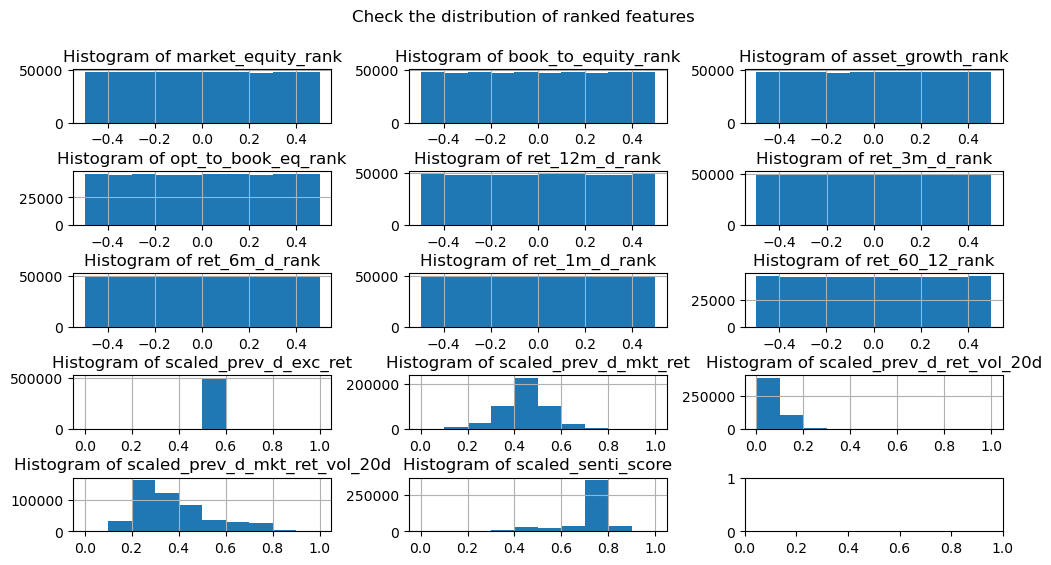

In [ ]:
# Data engineering / preprocessing
ticker_list = []
print ('Processing training data (train_val actually)..')
train_val_used, sel_features_adj = feature_engineer_dl(train_val_sp500, train_val_mkt, ticker_list, check_visual=False, senti_used=train_val_senti)

print ('\nProcessing testing data..')
test_used, sel_features_adj = feature_engineer_dl(test_sp500, test_mkt, ticker_list, check_visual=True, senti_used=test_senti)

In [ ]:
sel_features_adj

['market_equity_rank',
 'book_to_equity_rank',
 'asset_growth_rank',
 'opt_to_book_eq_rank',
 'ret_12m_d_rank',
 'ret_3m_d_rank',
 'ret_6m_d_rank',
 'ret_1m_d_rank',
 'ret_60_12_rank',
 'scaled_prev_d_exc_ret',
 'scaled_prev_d_mkt_ret',
 'scaled_prev_d_ret_vol_20d',
 'scaled_prev_d_mkt_ret_vol_20d',
 'scaled_senti_score']

### Building the dataset object for pytorch modeling

In [ ]:
class DL_dataset(Dataset):
    def __init__(self, initial_data, rebal_freq, window_days, feature_cols, tgt_cols):
        self.data = []
        self.dates = []  # the dates corresponding to the sample (x,y)
        self.permnos = [] # the list of permno_id whose returns are predicted for each rebal date
        self.rebal_freq = rebal_freq # IN: 'D', 'W', 'M'
        if (initial_data['date'].unique()[0].year == 2000)&\
                initial_data['date'].unique()[0].month == 1:
            self.dates_daily = initial_data['date'].unique()[20:]
            # the first available date for features is the first date of the second month of all data
        else:
            self.dates_daily = initial_data['date'].unique()
        self.dates_weekly = pd.Series(np.ones(len(self.dates_daily)), \
                               index=pd.DatetimeIndex(self.dates_daily)).asfreq('W-WED').index
        self.dates_monthly = pd.Series(np.ones(len(self.dates_daily)), \
                                index=pd.DatetimeIndex(self.dates_daily)).asfreq('ME').index
        self.window_days = window_days
        self.feature_cols = feature_cols
        self.tgt_cols = tgt_cols

        # create rolling windows group by date across different stocks
        if self.rebal_freq == 'D':
            self.rebal_dates = self.dates_daily
        elif self.rebal_freq == 'W':
            self.rebal_dates = self.dates_weekly
        elif self.rebal_freq == 'M':
            self.rebal_dates = self.dates_monthly

        initial_data = initial_data.sort_values(['date','permno'])
        #just to make sure it's in the right order but it should already been

        for i, date in enumerate(self.rebal_dates):
            if i%252==0:
                print (date)
            ''' create rolling samples'''

            index_in_daily_dates = list(self.dates_daily).index(self.dates_daily[self.dates_daily<=date][-1])

            date_period = self.dates_daily[max(0,(index_in_daily_dates+1)-self.window_days*1)
                                        :max(self.window_days*1, (index_in_daily_dates+1))]
            # extract rolling window data
            #IN: use this method to line up x and y stocks; short rolling window ok to ffill
            # revised (no multiply by excess return for each feature)
            data_t = initial_data[initial_data['date'].isin(date_period)][self.feature_cols+['date','permno']]

            ## prepare the Y data
            # df_x = data_t[sel_features_adj].apply(lambda x: x*data_t['prev_d_exc_ret'], axis=0).ffill()
            if rebal_freq == 'M':
                match_date = self.dates_daily[(self.dates_daily.month==date.month)
                                            &(self.dates_daily.year==date.year)][-1]
            elif rebal_freq == 'W':
                match_date = self.dates_daily[(self.dates_daily<=date)][-1]
            else:
                match_date = date

            target_data = initial_data[initial_data['date']==match_date][['permno']+self.tgt_cols].sort_values('permno')
            # regulate the number of stocks per day as the same for later modeling purpose (e.g. transformer need inputs are of same dimension)
            if len(target_data)<500:
                pad_df = pd.DataFrame(np.ones((500-len(target_data),len(target_data.columns))),
                                      columns = target_data.columns,
                                        index = list(500 + np.arange(500-len(target_data))))
                target_data = pd.concat([target_data, pad_df])
            else:
                target_data = target_data.iloc[:500,:] # if target_data has >=500 rows, only take the first 500 rows

            y = target_data[self.tgt_cols].values # shape: (num_stocks,)
            permnos_t = target_data['permno'].tolist()

            # convert y to torch tensor
            y = torch.tensor(y, dtype=torch.float32).nan_to_num()

            ## prepare the X data
            # pivot so that each stock has its own row, with window_days sequences as columns (values are the multiple columns)
            data_t_adj = data_t[data_t['permno'].isin(permnos_t)]
            pivoted_data_t = data_t_adj.pivot(index='permno', columns='date')

            # reshape the pivoted_data
            X = pivoted_data_t.values.reshape(pivoted_data_t.shape[0], len(date_period), -1)
            # using len(date_period) instead of just the window_days, just in case certain period have odd days at the start or end period

            # to make sure X have the same shapes for later processing, padding to 500, 252 to dimension 0 and 1 (latter may not be needed)
            if pivoted_data_t.shape[0]<500:
                n_pad_0 = 500-pivoted_data_t.shape[0]
                X = np.pad(X, ((0, n_pad_0), (0, 0), (0, 0)), mode='constant', constant_values=0)

            X = torch.tensor(X, dtype=torch.float32).nan_to_num() # this by default change nan to 0, and pos/neg inf to large finite float
            # drop all stocks whose features are nan at the last day of this window
            # (i.e. most likely have component change within the window, using the last day stock as target in this window, matching the predicted target)
            # after this operation, each X should almost always close to 500 stocks, i.e. first dimension: ~500 (note: it is still not always 500)

            # append the current sample
            self.data.append((X,y))
            self.dates.append(torch.tensor(match_date.timestamp()))    # convert datetime into torch.tensor, otherwise model can't batch
            self.permnos.append(torch.tensor(permnos_t))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # return self.data[idx]   #(X,y) for a specific day across all stocks
        return {
            'features': self.data[idx][0],
            'target': self.data[idx][1],
            'date': self.dates[idx],
            'permnos': self.permnos[idx]
        }

    def check_sample_dimension_match(self):
        mismatch_l = []
        for i in range(len(self.data)):
            if self.data[i][0].shape[0]!=self.data[i][1].shape[0]:
                mismatch_l.append((i, (self.data[i][0].shape, self.data[i][1].shape)))
        return mismatch_l

In [ ]:
%%time 
# Create the dataset based on the needs
window_days = 128  #252, 128, 3
feature_cols = sel_features_adj
tgt_cols = ['excess_ret', 'ret_vol_20d', 'mkt_ret_vol_20d', 'abs_ret', 'next_5d_ret', 'next_5d_abs_ret']  
#['excess_ret'] #['excess_ret', 'ret_vol_20d', 'mkt_ret_vol_20d']
rebal_freq = 'D' # 'M','W','D'

# split train and val
train_used = train_val_used[train_val_used['date']<='2016-12-31']
val_used = train_val_used[train_val_used['date']>'2016-12-31']
train_mkt = train_val_mkt.loc[:'2017-01-01',:]
val_mkt = train_val_mkt.loc['2017-01-01':,:]

# add train_val_adj (exclude 2020 covid outlier) for final model train (may not even needed for training purpse)
# train_val_adj = train_val_used[(train_val_used['date']<'2020-02-20')| \
#                                     (train_val_used['date']>'2020-04-07')]

train_val_adj = train_val_used[train_val_used['date']<'2020-01-01']

# traditional train/val split (one-time-split)
print ('Make train dataset..')
train_dataset_dl = DL_dataset(train_used, rebal_freq, window_days, feature_cols, tgt_cols)
print ('\tMake validation dataset..')
val_dataset_dl = DL_dataset(val_used, rebal_freq, window_days, feature_cols, tgt_cols)
print ('\tMake test dataset..')
test_dataset_dl = DL_dataset(test_used, rebal_freq, window_days, feature_cols, tgt_cols)

Make train dataset..
2000-02-01 00:00:00
2001-01-31 00:00:00
2002-02-06 00:00:00
2003-02-06 00:00:00
2004-02-06 00:00:00
2005-02-07 00:00:00
2006-02-07 00:00:00
2007-02-08 00:00:00
2008-02-08 00:00:00
2009-02-09 00:00:00
2010-02-09 00:00:00
2011-02-08 00:00:00
2012-02-08 00:00:00
2013-02-11 00:00:00
2014-02-11 00:00:00
2015-02-11 00:00:00
2016-02-11 00:00:00
	Make validation dataset..
2017-01-03 00:00:00
2018-01-03 00:00:00
2019-01-04 00:00:00
2020-01-06 00:00:00
	Make test dataset..
2021-01-04 00:00:00
2022-01-03 00:00:00
2023-01-04 00:00:00
2024-01-05 00:00:00
CPU times: user 59min 55s, sys: 6min 26s, total: 1h 6min 22s
Wall time: 4min 11s


### Save / Load post processing data

In [ ]:
# save data (post preprocessing before datasets)
# make post processing data dic
post_process_data_dic = {'train_val_used': train_val_used, 'test_used': test_used, 'train_used': train_used, 'val_used': val_used, \
                         'train_val_mkt': train_val_mkt, 'test_mkt': test_mkt, 'train_mkt': train_mkt, 'val_mkt': val_mkt, 
                        'train_val_adj': train_val_adj}

## if saving in s3
s3_folder = 's3://capstone-general/NN-related/dl_model/'
dl_model_checkpoint = 'dl_model_checkpoint0'
rebal_freq = 'D'
dl_model_directory = f'{s3_folder}{dl_model_checkpoint}/{rebal_freq}/'

with fs.open(f'{dl_model_directory}post_process_data_dic.pkl', 'wb') as f:
    pickle.dump(post_process_data_dic, f)

In [ ]:
# load data (post preprocessing before datasets)

## if saved in s3
s3_folder = 's3://capstone-general/NN-related/dl_model/'
dl_model_checkpoint = 'dl_model_checkpoint0'
rebal_freq = 'D'
dl_model_directory = f'{s3_folder}{dl_model_checkpoint}/{rebal_freq}/'

with fs.open(f'{dl_model_directory}post_process_data_dic.pkl', 'rb') as f:
    post_process_data_dic = pickle.load(f)

# get post processing data
train_val_used = post_process_data_dic['train_val_used']
test_used = post_process_data_dic['test_used'] 
train_used = post_process_data_dic['train_used']
val_used = post_process_data_dic['val_used'] 
train_val_adj = post_process_data_dic['train_val_adj']

train_val_mkt = post_process_data_dic['train_val_mkt']
test_mkt = post_process_data_dic['test_mkt']
train_mkt = post_process_data_dic['train_mkt'] 
val_mkt = post_process_data_dic['val_mkt']

### Save / Load dataset

In [ ]:
# save datasets
dl_model_checkpoint = 'dl_model_checkpoint0'
dl_model_directory = f'/home/sagemaker-user/user-default-efs/dl_model/{dl_model_checkpoint}/D/' ## for sm ; folder: 'monthly', 'weekly', 'daily'

def save_dataset(train_dataset_dl, val_dataset_dl, test_dataset_dl,\
                 train_dataset_dates, val_dataset_dates, test_dataset_dates,\
                 model_dir, version_no, is_s3=False):
    if is_s3 is False:
        with open(f'{model_dir}train_dataset_dl_{version_no}.pkl', 'wb') as f:
            pickle.dump(train_dataset_dl, f)
        with open(f'{model_dir}val_dataset_dl_{version_no}.pkl', 'wb') as f:
            pickle.dump(val_dataset_dl, f)
        with open(f'{model_dir}test_dataset_dl_{version_no}.pkl', 'wb') as f:
            pickle.dump(test_dataset_dl, f)
            
        with open(f'{model_dir}train_dataset_dates_{version_no}.pkl', 'wb') as f:
            pickle.dump(train_dataset_dates, f)
        with open(f'{model_dir}val_dataset_dates_{version_no}.pkl', 'wb') as f:
            pickle.dump(val_dataset_dates, f)
        with open(f'{model_dir}test_dataset_dates_{version_no}.pkl', 'wb') as f:
            pickle.dump(test_dataset_dates, f)
            
    elif is_s3 is True:
        with fs.open(f'{model_dir}train_dataset_dl_{version_no}.pkl', 'wb') as f:
            pickle.dump(train_dataset_dl, f)
        with fs.open(f'{model_dir}val_dataset_dl_{version_no}.pkl', 'wb') as f:
            pickle.dump(val_dataset_dl, f)
        with fs.open(f'{model_dir}test_dataset_dl_{version_no}.pkl', 'wb') as f:
            pickle.dump(test_dataset_dl, f)
            
        with fs.open(f'{model_dir}train_dataset_dates_{version_no}.pkl', 'wb') as f:
            pickle.dump(train_dataset_dates, f)
        with fs.open(f'{model_dir}val_dataset_dates_{version_no}.pkl', 'wb') as f:
            pickle.dump(val_dataset_dates, f)
        with fs.open(f'{model_dir}test_dataset_dates_{version_no}.pkl', 'wb') as f:
            pickle.dump(test_dataset_dates, f)

# execute datasets saving
save_dataset(train_dataset_dl, val_dataset_dl, test_dataset_dl,\
                 train_dataset_dates, val_dataset_dates, test_dataset_dates,\
                 dl_model_directory, version_no=9, is_s3=False)

In [ ]:
# load saved datasets
dl_model_checkpoint = 'dl_model_checkpoint0'
dl_model_directory = f'/home/sagemaker-user/user-default-efs/dl_model/{dl_model_checkpoint}/D/' ## for sm ; folder: 'monthly', 'weekly', 'daily'
#Note: xxx_dataset_dl.pkl have original 9 features, xxx_dataset_dl_2.pkl have 11 features

def load_train_val_dataset(model_dir, version_no, is_s3=False):

    if is_s3:
        with fs.open(f'{model_dir}train_dataset_dl_{version_no}.pkl', 'rb') as f:
            train_dataset = pickle.load(f)
        with fs.open(f'{model_dir}val_dataset_dl_{version_no}.pkl', 'rb') as f:
            val_dataset = pickle.load(f)
    else:
        with open(f'{model_dir}train_dataset_dl_{version_no}.pkl', 'rb') as f:
            train_dataset = pickle.load(f)
        with open(f'{model_dir}val_dataset_dl_{version_no}.pkl', 'rb') as f:
            val_dataset = pickle.load(f)

    return train_dataset, val_dataset


def load_test_dataset(model_dir, version_no, is_s3=False):
    if is_s3:
        with fs.open(f'{model_dir}test_dataset_dl_{version_no}.pkl', 'rb') as f:
            test_dataset = pickle.load(f)
    else:
        with open(f'{model_dir}test_dataset_dl_{version_no}.pkl', 'rb') as f:
            test_dataset = pickle.load(f)
    return test_dataset


train_dataset_dl, val_dataset_dl = load_train_val_dataset(dl_model_directory, version_no='9')
test_dataset_dl = load_test_dataset(dl_model_directory, version_no='9')

train_dataset_dates = [pd.Timestamp.fromtimestamp(item['date'].item()).normalize() for item in train_dataset_dl]
val_dataset_dates = [pd.Timestamp.fromtimestamp(item['date'].item()).normalize() for item in val_dataset_dl]
test_dataset_dates = [pd.Timestamp.fromtimestamp(item['date'].item()).normalize() for item in test_dataset_dl]

In [ ]:
selected_idx_bf = [idx for idx, item in enumerate(val_dataset_dl) if \
                (pd.Timestamp.fromtimestamp(item['date'].item()).normalize()< datetime.strptime('2020-01-01','%Y-%m-%d'))]

selected_idx_af = [idx for idx, item in enumerate(val_dataset_dl) if \
                (pd.Timestamp.fromtimestamp(item['date'].item()).normalize()>= datetime.strptime('2020-01-01','%Y-%m-%d'))]

val_dataset_dl_adj = Subset(val_dataset_dl, selected_idx_bf) #val dataset before 2020
val_dataset_dl_adj_rm = Subset(val_dataset_dl, selected_idx_af) #val dataset since 2020

# concat train_val dataset and loader for later use
train_val_dataset_dl = ConcatDataset([train_dataset_dl, val_dataset_dl])
train_val_dataset_dl_adj = ConcatDataset([train_dataset_dl, val_dataset_dl_adj])

### Prepare batch loader

In [ ]:
# Prepare the batch loader (incorporate in distribution)
if torch.cuda.is_available() and torch.cuda.device_count()>1:
    is_distributed = True
    print (f'Use {torch.cuda.device_count()} GPUs..')
else:
    is_distributed = False 

batch_size = 3 
train_dataloader_dl = DataLoader(train_dataset_dl, batch_size, shuffle=False) #IN: make sure do not shuffle for time series data

val_dataloader_dl = DataLoader(val_dataset_dl, batch_size, shuffle=False) #IN: make sure do not shuffle for time series data
test_dataloader_dl = DataLoader(test_dataset_dl, batch_size, shuffle=False) #IN: make sure do not shuffle for time series data

val_dataloader_dl_adj_rm = DataLoader(val_dataset_dl_adj_rm, batch_size, shuffle=False) #IN: make sure do not shuffle for time series data

# prepare train_val loader for later use
train_val_dataloader_dl = DataLoader(train_val_dataset_dl, batch_size, shuffle=False)

train_val_dataloader_dl_adj = DataLoader(train_val_dataset_dl_adj, batch_size, shuffle=False)

Use 4 GPUs..


In [ ]:
# check dataloader shape
for batch_idx, batch_item in enumerate(train_dataloader_dl):
  print (batch_item['features'].shape)
  print(batch_item['target'].shape)
  print(batch_item['date'].shape)
  print(batch_item['permnos'].shape)
  # print(len(batch_item['permnos']), len(batch_item['permnos'][0]))
  # print(pd.DataFrame(batch_item['permnos']).T.shape)
  break

torch.Size([3, 500, 128, 14])
torch.Size([3, 500, 6])
torch.Size([3])
torch.Size([3, 500])


## Modeling

### Classes Set Up

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_dim % num_heads == 0 #embed_dim must be divisible by num_heads

        self.num_heads = num_heads
        self.head_dim = embed_dim//num_heads

        self.query = nn.Linear(embed_dim,embed_dim)
        self.key = nn.Linear(embed_dim,embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.scale = nn.Linear(embed_dim,embed_dim)
        # final projection layer
        self.fc_out = nn.Linear(embed_dim,embed_dim)

        self.scaler = torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))

    def forward(self, x):
        # x: [batch_size, stock_num, embed_dim]
        batch_size, stock_num, embed_dim = x.shape

        # compute Q,K,V
        Q = self.query(x).reshape(batch_size, stock_num, self.num_heads, self.head_dim).transpose(1,2) #transpose(1,2) is to swap dimension 1 and 2
        K = self.key(x).reshape(batch_size, stock_num, self.num_heads, self.head_dim).transpose(1,2)
        V = self.value(x).reshape(batch_size, stock_num, self.num_heads, self.head_dim).transpose(1,2)

        # Scaled dot-product attention
        attn_weights = torch.softmax((Q@K.transpose(-2,-1))/self.scaler, dim=-1)
        # [batch_size, head_num, stock_num, stock_num], each head will do it seperately so what participate in the doc product are just the last two dimension
        # dim=1, menas we apply the softmax operation across the row (for each sample in batch); in this case will be the same as dim=-1
        attn_output = attn_weights @ V
        # weighted sum across stocks for each feature;
        # each row of attn_weights modified each col of V; [batch_size, head_num, stock_num, embed_dim_per_head]

        # merge heads back
        attn_output = attn_output.transpose(1,2).reshape(batch_size, stock_num, embed_dim)

        # final linear transformation
        output = self.fc_out(attn_output)

        return output

In [ ]:
class ReturnPredictionModel_SelfAttention(nn.Module):
    def __init__(self, input_dim=9, lstm_dim=64, lstm_layers=10,
                 num_heads=8, hidden_dims_l=[128,32], dropout=0.3, output_dim=1):
        super(ReturnPredictionModel_SelfAttention, self).__init__()

        # set up LSTM layer to extract temporal feature for each stock
        self.lstm = nn.LSTM(input_dim, lstm_dim,
                            num_layers = lstm_layers,
                            batch_first=True,
                            bidirectional=True)
        # batch_first: if the first dimension is batch size
        # bidirectional=True means process in both directions, then the final cell state has two embeddings

        # set up sel-attention layer
        self.attention = MultiHeadSelfAttention(lstm_dim*2, num_heads) # bidirectional=True, thus *2

        # set sequantial non linear layer
        # self.hidden_layers = nn.ModuleList()
        hidden_layers_l = []
        last_hidden_layer_dim = lstm_dim*2 # bidirectional=True, thus *2
        for i in range(len(hidden_dims_l)):
            hidden_seq = [nn.Linear(last_hidden_layer_dim, hidden_dims_l[i]),
                nn.ReLU(),
                nn.Dropout(dropout)]
            last_hidden_layer_dim = hidden_dims_l[i]
            hidden_layers_l.extend(hidden_seq)
        self.hidden_layers = nn.Sequential(*hidden_layers_l)

        # fianl prediction layer
        self.fc = nn.Linear(hidden_dims_l[-1], output_dim)

    def forward(self, x):
        # x: shape: [batch_size, stock_num, seq_len, input_feat_dim]

        batch_size, stock_num, seq_len, input_feat_dim = x.shape

        # reshape the input to [batch_size*stock_num, seq_len, input_feat_dm] for LSTM
        x = x.view(batch_size*stock_num, seq_len, input_feat_dim)

        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)
        # h_n shape: num_layers*num_directions, batch_size*stock_num, hidden_dim
        # note: h_n[-1] is the same as h_n[-1,:,:] here
        # note: c_n[-1] is more representation with more memory of the sequence
        # h_c[-1] is more affected by the 'current time stamp'
        # final_lstm_rep shoudl be of shape: batch_size, stock_num, hidden_dim
        # if to use didirectional=False:
        # final_lstm_rep = c_n[-1].view(batch_size, stock_num, -1) # reshape to desired shape for following process
        
        # if to use bidirectional=True, then need to concate the last two layers
        c_last_forward, c_last_backward = c_n[-2], c_n[-1]
        c_last_comb = torch.cat((c_last_forward, c_last_backward), dim=1) # shape: batch_size*stock_num, hidden_dim
        final_lstm_rep = c_last_comb.view(batch_size, stock_num, -1) # shape: batch_size, stock_num, 2*hidden_dim
        
        # self-attention
        attention_output = self.attention(final_lstm_rep)

        # non-linear layers
        hidden_layer_output = self.hidden_layers(attention_output)
        
        # last layer for prediction
        output = self.fc(hidden_layer_output) # output: [batch_size, stock_num, output_dim (here is 1)]

        return output

In [ ]:
class ReturnPredictionModel_Transformer(nn.Module):
    def __init__(self, input_dim=9, lstm_dim=64, lstm_layers=5, transformer_layers=3,
                 num_heads=4, attn_dropout=0.1, forward_dim=5, hidden_dims_l=[128,32], dropout=0.3, output_dim=1):
        super(ReturnPredictionModel_Transformer, self).__init__()

        # set up LSTM layer to extract temporal feature for each stock
        self.lstm = nn.LSTM(input_dim, lstm_dim,
                            num_layers = lstm_layers,
                            batch_first=True,
                            bidirectional=True)
        # batch_first: if the first dimension is batch size
        # bidirectional=True means process in both directions

        # set up transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model = lstm_dim*2, # lstm output dim; bidirectional=True, thus *2
            nhead = num_heads, # number of attention heads
            dim_feedforward = forward_dim, # feedforeward layer inside each transformer layer
            dropout = attn_dropout,
            batch_first = True,
            activation='gelu' # added later
        )
        self.transformer = nn.TransformerEncoder(encoder_layer,
                                                num_layers = transformer_layers)

        # set sequantial non linear layer
        hidden_layers_l = []
        last_hidden_layer_dim = lstm_dim*2 # bidirectional=True, thus *2
        for i in range(len(hidden_dims_l)):
            hidden_seq = [nn.Linear(last_hidden_layer_dim, hidden_dims_l[i]),
                nn.ReLU(),
                nn.Dropout(dropout)]
            last_hidden_layer_dim = hidden_dims_l[i]
            hidden_layers_l.extend(hidden_seq)
        self.hidden_layers = nn.Sequential(*hidden_layers_l)

        # final prediction layer
        self.fc = nn.Linear(hidden_dims_l[-1], output_dim)

    def forward(self, x):
        # x: shape: [batch_size, stock_num, seq_len, input_feat_dim]

        batch_size, stock_num, seq_len, input_feat_dim = x.shape

        # reshape the input to [batch_size*stock_num, seq_len, input_feat_dim] for LSTM
        x = x.view(batch_size*stock_num, seq_len, input_feat_dim)

        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # if to use bidirectional=True, then need to concate the last two layers
        c_last_forward, c_last_backward = c_n[-2], c_n[-1]
        c_last_comb = torch.cat((c_last_forward, c_last_backward), dim=1) # shape: batch_size*stock_num, hidden_dim
        final_lstm_rep = c_last_comb.view(batch_size, stock_num, -1) # shape: batch_size, stock_num, 2*hidden_dim
        
        # transformer
        transformer_output = self.transformer(final_lstm_rep)

        # non-linear layers
        hidden_layer_output = self.hidden_layers(transformer_output)
        
        # last layer for prediction
        output = self.fc(hidden_layer_output) # output == input dim: [batch_size, stock_num, 1]

        return output, transformer_output


In [ ]:
class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.query = nn.Parameter(torch.randn(hidden_dim, 1))  # Trainable query vector

    def forward(self, embeddings):
        """
        embeddings: Tensor of shape (batch_size, seq_len, hidden_dim)
        """
        attn_scores = torch.matmul(embeddings, self.query).squeeze(-1)  # (batch_size, seq_len)
        attn_weights = torch.softmax(attn_scores, dim=-1)  # Normalize scores
        pooled_embedding = torch.sum(embeddings * attn_weights.unsqueeze(-1), dim=1)  # (batch_size, hidden_dim)
        return pooled_embedding

In [ ]:
class ReturnPredictionModel_Transformer_square(nn.Module):
    def __init__(self, input_dim=13, embed_dim=256, window_size=128,
                 transformer_layers_seq=2, num_heads_seq=4, attn_dropout_seq=0.1, forward_dim_seq=64, 
                 transformer_layers_cs=1, num_heads_cs=4, attn_dropout_cs=0.1, forward_dim_cs=3, 
                 hidden_dims_l=[252,128], dropout=0.3, output_dim=6):
        super(ReturnPredictionModel_Transformer_square, self).__init__()

        self.embed_dim = embed_dim
        self.seq_len = window_size # assuming fixed sequence length, if not then need to create seperate function to do positioning embedding
        
        # projection layer/encoding layer
        self.input_projection = nn.Linear(input_dim, embed_dim)
        
        # create a trainable positional embedding
        pos = torch.arange(self.seq_len, dtype=torch.float32).unsqueeze(1).repeat(1, embed_dim)
        min_pos = pos.min(dim=0, keepdim=True).values  # Extract the min values
        max_pos = pos.max(dim=0, keepdim=True).values  # Extract the max values
        pos = (pos-min_pos)/(max_pos - min_pos) # min-max normalization 
        self.pos_embedding = nn.Parameter(pos) # now it's a trainable parameter

        # special token embedding (learnable)
        self.special_token_embedding = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # set up transformer encoder layer for seq
        encoder_layer_seq = nn.TransformerEncoderLayer(
            d_model = embed_dim, # first trsf output dim
            nhead = num_heads_seq, # number of attention heads
            dim_feedforward = forward_dim_seq, # feedforeward layer inside each transformer layer
            dropout = attn_dropout_seq,
            batch_first = True,
            activation='gelu' # added later
        )
        self.transformer_seq = nn.TransformerEncoder(encoder_layer_seq,
                                                num_layers = transformer_layers_seq)   

        # Attention pooling (Move it here!) - to make sure it is constructed here so all are the same device
        # self.attention_pooling = AttentionPooling(embed_dim)
        
        # set up transformer encoder layer for cs
        encoder_layer_cs = nn.TransformerEncoderLayer(
            d_model = embed_dim, # first trf output dim; if concat: embed_dim * self.seq_len
            nhead = num_heads_cs, # number of attention heads
            dim_feedforward = forward_dim_cs, # feedforeward layer inside each transformer layer
            dropout = attn_dropout_cs,
            batch_first = True,
            activation='gelu' # added later
        )
        self.transformer_cs = nn.TransformerEncoder(encoder_layer_cs,
                                                num_layers = transformer_layers_cs)

        # set sequantial non linear layer
        hidden_layers_l = []
        last_hidden_layer_dim = embed_dim # if concat: embed_dim* self.seq_len
        for i in range(len(hidden_dims_l)):
            hidden_seq = [nn.Linear(last_hidden_layer_dim, hidden_dims_l[i]),
                nn.ReLU(),
                nn.Dropout(dropout)]
            last_hidden_layer_dim = hidden_dims_l[i]
            hidden_layers_l.extend(hidden_seq)
        self.hidden_layers = nn.Sequential(*hidden_layers_l)

        # final prediction layer
        self.fc = nn.Linear(hidden_dims_l[-1], output_dim)

    def forward(self, x):
        # x: shape: [batch_size, stock_num, seq_len, input_feat_dim]

        batch_size, stock_num, seq_len, input_feat_dim = x.shape

        # check if current batch seq_len is the same as pre-set window size
        if seq_len != self.seq_len:
            raise ValueError(f'Expected seq_len={self.seq_len}, but got {seq_len}.')

        # reshape the input to [batch_size*stock_num, seq_len, input_feat_dim] for LSTM
        x = x.view(batch_size*stock_num, seq_len, input_feat_dim)
         
        # project the shape
        x = self.input_projection(x) # batch_size*stock_num, seq_len, embed_dim

        # Compute position embeddings using local normalization
        x = x+self.pos_embedding  # (batch_size * stock_num, seq_len, embed_dim)

        # add special token at the beginning of each sequence
        special_token = self.special_token_embedding.expand(batch_size*stock_num, -1, -1)  # (batch_size * stock_num, 1, embed_dim)
        x = torch.cat([special_token, x], dim=1) # (batch_size * stock_num, seq_len + 1, embed_dim)
        
        # transformer_seq
        transformer_output_seq = self.transformer_seq(x) # batch_size*stock_num, seq_len, embed_dim
        # print (transformer_output_seq.shape)
        
        ## method five: extract embedding from special token
        special_token_rep = transformer_output_seq[:,0,:] # (batch_size * stock_num, 1, embed_dim)
        transformer_output_seq_pooled = special_token_rep.reshape(batch_size, stock_num, -1) # (batch_size, stock_num, embed_dim)
        
        # transformer_cs
        transformer_output_cs = self.transformer_cs(transformer_output_seq_pooled)
        # note: the input of transformer is of [batch_size, stock_num, hidden_dim]
        # non-linear layers
        hidden_layer_output = self.hidden_layers(transformer_output_cs)
        # hidden_layer_output = self.hidden_layers(transformer_output_seq_pooled) #if skipping the second transformer
        # print ('hidden')
        # print (hidden_layer_output.shape)
        # last layer for prediction
        output = self.fc(hidden_layer_output) # output == input dim: [batch_size, stock_num, 1]

        return output, hidden_layer_output

In [ ]:
class ReturnPredictionModel_Transformer_square_tune(nn.Module):
    def __init__(self, input_dim=13, embed_dim=128, window_size=128,
                 transformer_layers_seq=2, num_heads_seq=4, attn_dropout_seq=0.1, forward_dim_seq=64, 
                 transformer_layers_cs=1, num_heads_cs=4, attn_dropout_cs=0.1, forward_dim_cs=3, 
                 hidden_layers_num =2, dropout=0.3, output_dim=6):
        super(ReturnPredictionModel_Transformer_square_tune, self).__init__()

        self.embed_dim = embed_dim
        self.seq_len = window_size # assuming fixed sequence length, if not then need to create seperate function to do positioning embedding
        
        # projection layer/encoding layer
        self.input_projection = nn.Linear(input_dim, embed_dim)
        
        # create a trainable positional embedding
        pos = torch.arange(self.seq_len, dtype=torch.float32).unsqueeze(1).repeat(1, embed_dim)
        min_pos = pos.min(dim=0, keepdim=True).values  # Extract the min values
        max_pos = pos.max(dim=0, keepdim=True).values  # Extract the max values
        pos = (pos-min_pos)/(max_pos - min_pos) # min-max normalization 
        self.pos_embedding = nn.Parameter(pos) # now it's a trainable parameter

        # special token embedding (learnable)
        self.special_token_embedding = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # set up transformer encoder layer for seq
        encoder_layer_seq = nn.TransformerEncoderLayer(
            d_model = embed_dim, # first trsf output dim
            nhead = num_heads_seq, # number of attention heads
            dim_feedforward = forward_dim_seq, # feedforeward layer inside each transformer layer
            dropout = attn_dropout_seq,
            batch_first = True,
            activation='gelu' # added later
        )
        self.transformer_seq = nn.TransformerEncoder(encoder_layer_seq,
                                                num_layers = transformer_layers_seq)   

        # Attention pooling (Move it here!) - to make sure it is constructed here so all are the same device
        # self.attention_pooling = AttentionPooling(embed_dim)
        
        # set up transformer encoder layer for cs
        encoder_layer_cs = nn.TransformerEncoderLayer(
            d_model = embed_dim, # first trf output dim; if concat: embed_dim * self.seq_len
            nhead = num_heads_cs, # number of attention heads
            dim_feedforward = forward_dim_cs, # feedforeward layer inside each transformer layer
            dropout = attn_dropout_cs,
            batch_first = True,
            activation='gelu' # added later
        )
        self.transformer_cs = nn.TransformerEncoder(encoder_layer_cs,
                                                num_layers = transformer_layers_cs)

        # set sequantial non linear layer
        hidden_layers_l = []
        last_hidden_layer_dim = embed_dim # if concat: embed_dim* self.seq_len
        for i in range(hidden_layers_num):
            if i==0:
                cur_output_hidden_layer_dim = last_hidden_layer_dim*2
            else:
                cur_output_hidden_layer_dim = last_hidden_layer_dim//2
            hidden_seq = [nn.Linear(last_hidden_layer_dim, cur_output_hidden_layer_dim),
                nn.ReLU(),
                nn.Dropout(dropout)]
            last_hidden_layer_dim = cur_output_hidden_layer_dim
            hidden_layers_l.extend(hidden_seq)
        self.hidden_layers = nn.Sequential(*hidden_layers_l)

        # final prediction layer
        self.fc = nn.Linear(last_hidden_layer_dim, output_dim)

    def forward(self, x):
        # x: shape: [batch_size, stock_num, seq_len, input_feat_dim]

        batch_size, stock_num, seq_len, input_feat_dim = x.shape

        # check if current batch seq_len is the same as pre-set window size
        if seq_len != self.seq_len:
            raise ValueError(f'Expected seq_len={self.seq_len}, but got {seq_len}.')

        # reshape the input to [batch_size*stock_num, seq_len, input_feat_dim] for LSTM
        x = x.view(batch_size*stock_num, seq_len, input_feat_dim)
         
        # project the shape
        x = self.input_projection(x) # batch_size*stock_num, seq_len, embed_dim

        # Compute position embeddings using local normalization
        x = x+self.pos_embedding  # (batch_size * stock_num, seq_len, embed_dim)

        # add special token at the beginning of each sequence
        special_token = self.special_token_embedding.expand(batch_size*stock_num, -1, -1)  # (batch_size * stock_num, 1, embed_dim)
        x = torch.cat([special_token, x], dim=1) # (batch_size * stock_num, seq_len + 1, embed_dim)
        
        # transformer_seq
        transformer_output_seq = self.transformer_seq(x) # batch_size*stock_num, seq_len, embed_dim

        ## method five: extract embedding from special token
        special_token_rep = transformer_output_seq[:,0,:] # (batch_size * stock_num, 1, embed_dim)
        transformer_output_seq_pooled = special_token_rep.reshape(batch_size, stock_num, -1) # (batch_size, stock_num, embed_dim)
        
        # transformer_cs
        transformer_output_cs = self.transformer_cs(transformer_output_seq_pooled)
        # non-linear layers
        hidden_layer_output = self.hidden_layers(transformer_output_cs)
        # print ('hidden')
        # print (hidden_layer_output.shape)
        # last layer for prediction
        output = self.fc(hidden_layer_output) # output == input dim: [batch_size, stock_num, 1]

        return output, hidden_layer_output

### Implementation of model - Single Run

#### Set up model to run

In [ ]:
# if not already set:
sel_features_adj = ['market_equity_rank',
 'book_to_equity_rank',
 'asset_growth_rank',
 'opt_to_book_eq_rank',
 'ret_12m_d_rank',
 'ret_3m_d_rank',
 'ret_6m_d_rank',
 'ret_1m_d_rank',
 'ret_60_12_rank',
 'scaled_prev_d_exc_ret',
 'scaled_prev_d_mkt_ret',
 'scaled_prev_d_ret_vol_20d',
 'scaled_prev_d_mkt_ret_vol_20d',
 'scaled_senti_score']

window_days = window_days  #252, 128, 3, 64
feature_cols = sel_features_adj
tgt_cols = ['excess_ret', 'ret_vol_20d', 'mkt_ret_vol_20d', 'abs_ret', 'next_5d_ret', 'next_5d_abs_ret'] 
#['excess_ret'], ['excess_ret', 'ret_vol_20d', 'mkt_ret_vol_20d']
rebal_freq = 'D' # 'M','W','D'

In [ ]:
## with added non-linear layers:
# if use self-attention
model_dl_att = ReturnPredictionModel_SelfAttention(
    input_dim = len(feature_cols),
    lstm_dim = 64,
    lstm_layers = 10,
    num_heads = 8,
    hidden_dims_l = [128, 32],
    dropout = 0.3,
    output_dim = len(tgt_cols)
)

# if use transformer
model_dl_trf = ReturnPredictionModel_Transformer(
    input_dim = len(feature_cols),
    lstm_dim = 64,
    lstm_layers = 8,
    transformer_layers = 1,
    num_heads = 2,
    attn_dropout = 0.1,
    forward_dim = 32,
    hidden_dims_l = [128, 32],
    dropout = 0.3,
    output_dim = len(tgt_cols)
)

# if use transformer_square
model_dl_trf_sq = ReturnPredictionModel_Transformer_square(
    input_dim = len(feature_cols),
    embed_dim = 128*2,
    window_size = window_days,
    transformer_layers_seq = 2, 
    num_heads_seq = 4,
    attn_dropout_seq = 0.1, 
    forward_dim_seq = 64,
    transformer_layers_cs = 1,
    num_heads_cs = 2,
    attn_dropout_cs = 0.1,
    forward_dim_cs = 3,
    hidden_dims_l = [252, 128],
    dropout = 0.25,
    output_dim = len(tgt_cols)
)

# if based on tuned results (manual param set):
model_df_trf_sq_tuned= ReturnPredictionModel_Transformer_square_tune(
    input_dim = len(feature_cols),
    embed_dim = 384,
    window_size = 128,
    transformer_layers_seq = 2, 
    num_heads_seq = 4,
    attn_dropout_seq = 0.1, 
    forward_dim_seq = 96,
    transformer_layers_cs = 1,
    num_heads_cs = 4,
    attn_dropout_cs = 0.1,
    forward_dim_cs = 3,
    hidden_layers_num = 2,
    dropout = 0.25,
    output_dim = len(tgt_cols)
)

model_dl = model_dl_trf_sq # model_dl_trf, model_dl_att, model_dl_trf_sq, model_df_trf_sq_tuned
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_dl.to(device)

In [ ]:
# define loss and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()

# learning_rate = 0.00005  # 0.00005
learning_rate = 0.000025  # 0.00005
optimizer = torch.optim.Adam(model_dl.parameters(), lr=learning_rate)
num_epochs = 30  # 20, 30
patience = 5

#### Clear memory

In [ ]:
import gc
# !export PYTORCH_CUDA_ALLOC_CONF="expandable_segments:True"

def clear_memory(model_dl, train_dataloader_dl, val_dataloader_dl, delete_model=None):
    if delete_model:
        print('here')
        del model_dl
        del train_dataloader_dl, val_dataloader_dl  # If applicable

    torch.cuda.empty_cache()
    gc.collect()
    # os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
clear_memory(model_dl, train_dataloader_dl, val_dataloader_dl, 1)

torch.cuda.reset_peak_memory_stats()
# torch.cuda.set_per_process_memory_fraction(0.8)

print(f"Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
# torch.cuda.memory_summary(device=None, abbreviated=False)

here
Allocated: 3.59 GB
Reserved: 4.97 GB


#### Set pytorch seed

In [ ]:
import torch
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Ensures reproducibility

def remove_seed():
    random.seed(None)  # Removes fixed seed from Python’s random module
    np.random.seed(None)  # Removes fixed seed from NumPy
    torch.seed()  # Resets PyTorch’s seed to a random one
    torch.backends.cudnn.deterministic = False  # Allows CuDNN to use non-deterministic algorithms
    torch.backends.cudnn.benchmark = True  # Enables optimizations that may introduce randomness
    
# Example usage
set_seed(42)
# Example usage
# remove_seed() #and need to restart the kernel

#### Train with data parallelism - with early stop

In [ ]:
%%time 
def train_model(model, train_dataloader, val_dataloader,
                criterion, optimizer, num_epochs, patience, 
                device, is_distributed, seed=42):
    # Writer will output to ./runs/ directory by default
    # writer = SummaryWriter(log_dir='runs/test')

    # if set up for parallelism using DDP
    if is_distributed:
        model = nn.DataParallel(model)

    model.to(device)

    model.train()
    train_loss_l = []
    val_loss_l = []
    best_loss = np.inf
    patience_counter = 0
    best_model_state = None
    # torch.cuda.manual_seed(seed) # for if using cuda
    torch.cuda.manual_seed_all(seed) # for if using cuda
    
    for epoch in range(num_epochs):
        model.train()
        train_loss_ep = 0
        val_loss_ep = 0 

        for batch_idx, batch_item in enumerate(train_dataloader):
            x_batch, y_batch = \
                batch_item['features'].to(device), \
                    batch_item['target'].to(device)

            optimizer.zero_grad()
            pred, _ = model(x_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step() 
            train_loss_ep +=loss.item()

        avg_train_loss_ep = train_loss_ep/len(train_dataloader)
        print (f'Epoch {epoch+1}/{num_epochs}, Train loss: {avg_train_loss_ep:.4f}')
        train_loss_l.append(avg_train_loss_ep)

        # log validation loss
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for batch_idx, batch_item in enumerate(val_dataloader):
                x_batch, y_batch = \
                    batch_item['features'].to(device), \
                        batch_item['target'].to(device)
                pred, _ = model(x_batch)
                loss = criterion(pred, y_batch)
                val_loss_ep+=loss.item()
        avg_val_loss_ep = val_loss_ep/len(val_dataloader)
        val_loss_l.append(avg_val_loss_ep)

        print (f'Epoch {epoch+1}/{num_epochs}, Val loss: {avg_val_loss_ep:.4f}')

        # check if stop early
        if avg_val_loss_ep < best_loss:
            best_loss = avg_val_loss_ep 
            patience_counter = 0 # reset patience counter once improved
            best_model_state = model.state_dict() # mark best model
        else:
            patience_counter +=1
        
        if patience_counter >= patience:
            print ('Early stopping triggered')
            break # stop training if validatio loss failed to keep reducing after > patience epochs
    
    # load best model weights
    if best_model_state is not None:
      model.load_state_dict(best_model_state)

    # writer.close()

    return model, train_loss_l, val_loss_l

CPU times: user 3 μs, sys: 3 μs, total: 6 μs
Wall time: 14.1 μs


In [ ]:
%%time
model_dl, train_loss_l, val_loss_l = train_model(model_dl, train_val_dataloader_dl_adj, val_dataloader_dl,
                criterion, optimizer, num_epochs, patience,
                device, is_distributed)

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/linear.py:117: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1728241823685/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)


Epoch 1/30, Train loss: 0.0191
Epoch 1/30, Val loss: 0.0147
Epoch 2/30, Train loss: 0.0160
Epoch 2/30, Val loss: 0.0146
Epoch 3/30, Train loss: 0.0156
Epoch 3/30, Val loss: 0.0145
Epoch 4/30, Train loss: 0.0153
Epoch 4/30, Val loss: 0.0145
Epoch 5/30, Train loss: 0.0152
Epoch 5/30, Val loss: 0.0145
Epoch 6/30, Train loss: 0.0150
Epoch 6/30, Val loss: 0.0145
Epoch 7/30, Train loss: 0.0149
Epoch 7/30, Val loss: 0.0144
Epoch 8/30, Train loss: 0.0147
Epoch 8/30, Val loss: 0.0144
Epoch 9/30, Train loss: 0.0146
Epoch 9/30, Val loss: 0.0143
Epoch 10/30, Train loss: 0.0145
Epoch 10/30, Val loss: 0.0141
Epoch 11/30, Train loss: 0.0144
Epoch 11/30, Val loss: 0.0139
Epoch 28/30, Train loss: 0.0136
Epoch 28/30, Val loss: 0.0132
Epoch 29/30, Train loss: 0.0136
Epoch 29/30, Val loss: 0.0132
Epoch 30/30, Train loss: 0.0135
Epoch 30/30, Val loss: 0.0132
CPU times: user 1d 2h 28min 49s, sys: 2h 17min 11s, total: 1d 4h 46min
Wall time: 1h 11min 23s


### HPO using native pytorch functions

In [ ]:
torch.cuda.empty_cache()
gc.collect()

print(f"Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

Allocated: 0.00 GB
Reserved: 0.00 GB


In [ ]:
# Example usage
set_seed(42)
# Example usage
# remove_seed() #and need to restart the kernel

In [ ]:
%%time
# potential hyperparameter code
def objective(trial):
    # Suggest values for hyperparameters
    embed_dim = trial.suggest_int("embed_dim", 64, 448, step=64)
    # window_size = trial.suggest_int('window_size', 64, 256, step=64)
    transformer_layers_seq = trial.suggest_int('transformer_layers_seq', 2,4)
    num_heads_seq = trial.suggest_categorical('num_heads_seq', [2,4]) 
    # attn_dropout_seq = trial.suggest_uniform('attn_dropout_seq', 0.1, 0.6) # deprecated
    attn_dropout_seq = trial.suggest_float('attn_dropout_seq', 0.05, 0.3)
    forward_dim_seq = trial.suggest_int('forward_dim_seq', 32, 128, step=32)
    transformer_layers_cs = trial.suggest_int('transformer_layers_cs', 1,3)
    num_heads_cs = trial.suggest_categorical('num_heads_cs', [2,4])
    # attn_dropout_cs = trial.suggest_uniform('attn_dropout_cs', 0.1,0.6) # deprecated
    attn_dropout_cs = trial.suggest_float('attn_dropout_cs', 0.05,0.3)
    # forward_dim_cs = trial.suggest_int('forward_dim_cs', 3, 128, step=1)
    forward_dim_cs = trial.suggest_int('forward_dim_cs', 2, 128, step=1)
    hidden_layers_num = trial.suggest_int('hidden_layers_num', 1,3, step=1) 
    # dropout = trial.suggest_uniform('dropout',0.1,0.5) # deprecated
    # dropout = trial.suggest_float('dropout',0.2,0.5)
    dropout = trial.suggest_float('dropout',0.1,0.5)
     
    # learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3) # deprecated
    # learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-3, log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True)
    # batch_size = trial.suggest_categorical("batch_size", [3,10,20,30])
    batch_size = trial.suggest_int("batch_size", 3,18,step=3)
    window_days = trial.suggest_categorical("window_days", [32,64,128])

    # set key constant parameters
    sel_features_adj_tr = ['market_equity_rank',
     'book_to_equity_rank',
     'asset_growth_rank',
     'opt_to_book_eq_rank',
     'ret_12m_d_rank',
     'ret_3m_d_rank',
     'ret_6m_d_rank',
     'ret_1m_d_rank',
     'ret_60_12_rank',
     'scaled_prev_d_exc_ret',
     'scaled_prev_d_mkt_ret',
     'scaled_prev_d_ret_vol_20d',
     'scaled_prev_d_mkt_ret_vol_20d']
     # 'scaled_senti_score']

    window_size = window_days
    feature_cols = sel_features_adj_tr
    tgt_cols = ['excess_ret', 'ret_vol_20d', 'mkt_ret_vol_20d', 'abs_ret', 'next_5d_ret', 'next_5d_abs_ret']  #['excess_ret', 'ret_vol_20d', 'mkt_ret_vol_20d'] #['excess_ret']
    rebal_freq = 'D'

    model_tr = ReturnPredictionModel_Transformer_square_tune(
        input_dim = len(feature_cols),
        embed_dim = embed_dim,
        window_size = window_size,
        transformer_layers_seq = transformer_layers_seq,
        num_heads_seq = num_heads_seq,
        attn_dropout_seq = attn_dropout_seq,
        forward_dim_seq = forward_dim_seq,
        transformer_layers_cs = transformer_layers_cs,
        num_heads_cs = num_heads_cs,
        attn_dropout_cs = attn_dropout_cs,
        forward_dim_cs = forward_dim_cs,
        hidden_layers_num = hidden_layers_num,
        dropout = dropout,
        output_dim = len(tgt_cols)
    )

    logger.info(f'\nTrail-{trial.number}:')
    # print (f'\nTrail-{trial.number}:')

    # traditional train/val split (one-time-split)
    logger.info('\nMake train dataset..')
    # print ('\nMake train dataset..')
    train_dataset_tr = DL_dataset(train_val_used[train_val_used['date']<='2016-12-31'], 
                                  rebal_freq, window_days, feature_cols, tgt_cols)
    logger.info('\nMake validation dataset..')
    # print ('\nMake validation dataset..')
    val_dataset_tr = DL_dataset(train_val_used[train_val_used['date']>'2016-12-31'], 
                                rebal_freq, window_days, feature_cols, tgt_cols)

    # Prepare the batch loader
    # print('\nMake dataloaders..')
    logger.info('\nMake dataloaders..')
    batch_size = batch_size # IN: assume half of a year's data as a batch, this hyperparameter could be tuned
    train_dataloader_tr = DataLoader(train_dataset_tr, batch_size, shuffle=False)
    val_dataloader_tr = DataLoader(val_dataset_tr, batch_size, shuffle=False)

    # Define loss function & optimizer
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)

    # train model for 10 epochs
    # print ('\nStart training..')
    logger.info('\nStart training..')
    model_tr, train_loss, val_loss = train_model(model_tr, train_dataloader_tr, val_dataloader_tr,
                criterion, optimizer, num_epochs_tr, patience_tr,
                device_tr, is_distributed_tr)

    # Save the trial's parameters and losses
    # print ('\nStart saving results..')
    logger.info('\nStart saving results..')
    trial_df = pd.DataFrame({
        'trial_number': [trial.number],
        'rebal_freq':[rebal_freq],
        'embed_dim': [embed_dim],
        'window_size': [window_size],
        'transformer_layers_seq': [transformer_layers_seq],
        'num_heads_seq': [num_heads_seq],
        'attn_dropout_seq': [attn_dropout_seq],
        'forward_dim_seq': [forward_dim_seq],
        'transformer_layers_cs': [transformer_layers_cs],
        'num_heads_cs': [num_heads_cs],
        'attn_dropout_cs': [attn_dropout_cs],
        'forward_dim_cs': [forward_dim_cs],
        'hidden_layers_num': [hidden_layers_num],
        'dropout': [dropout],
        'learning_rate': [learning_rate],
        'batch_size': [batch_size],
        'window_days': [window_days],
        'train_loss': [train_loss[-1]],
        'val_loss': [val_loss[-1]]
    })

    # Append the result to the DataFrame
    global trial_results
    trial_results = pd.concat([trial_results, trial_df], ignore_index=True)

    torch.cuda.empty_cache()
    gc.collect()

    return val_loss[-1]

# running:
# set up logs (real time so we can check the file during the training)
# Set up logging to ensure real-time updates
# set up saving directory (for outputs and logs)
rebal_freq = 'D'
study_checkpoint = 'study_checkpoint0'
study_dir =f'/home/sagemaker-user/user-default-efs/dl_model/{study_checkpoint}/{rebal_freq}'
study_filename = 'hpo_dl_v6'

log_file_path = f"{study_dir}/training_{study_filename}.log"  # Change as needed
logger = logging.getLogger("TrainingLogger")
logger.setLevel(logging.INFO)

# Create file handler to write logs
file_handler = logging.FileHandler(log_file_path, mode="w")  # 'w' overwrites the log each run
file_handler.setLevel(logging.INFO)

# Create console handler to also print logs to screen
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)

# Define log format
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S")
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Add handlers to logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

# Other key parameters:
num_epochs_tr = 20
patience_tr = 5
device_tr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available() and torch.cuda.device_count()>1:
    is_distributed_tr = True
    print (f'Use {torch.cuda.device_count()} GPUs..')
else:
    is_distributed_tr = False


# Initialize an empty DataFrame to store the results
global trial_results
# trial_results = pd.DataFrame() # enough?
trial_results = pd.DataFrame(columns=["trial_number", 'rebal_freq', "embed_dim", "window_size", "transformer_layers_seq", "num_heads_seq", 
                                "attn_dropout_seq", "forward_dim_seq", "transformer_layers_cs", "num_heads_cs",
                                "attn_dropout_cs", "forward_dim_cs", "hidden_layers_num", "dropout", 
                                "learning_rate", "batch_size", "window_days", "train_loss", "val_loss"])

# run optuna optimization
#if create new study
study = optuna.create_study(direction='minimize') 
#if load old study and continue
# study = joblib.load(f"{study_dir}/study.pkl")
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)

# study dump (not implemented yet)

joblib.dump(study, f"{study_dir}/study.pkl")
# print best hyperparameters

[I 2025-03-15 23:52:49,421] A new study created in memory with name: no-name-ce1bc2a3-6e4d-4bd5-954f-f9b103d13fdd
2025-03-15 23:52:49 - INFO - 
Trail-0:
2025-03-15 23:52:49 - INFO - 
Trail-0:
2025-03-15 23:52:49 - INFO - 
Make train dataset..
2025-03-15 23:52:49 - INFO - 
Make train dataset..


Use 4 GPUs..
2000-02-01 00:00:00
2001-01-31 00:00:00
2002-02-06 00:00:00
2003-02-06 00:00:00
2004-02-06 00:00:00
2005-02-07 00:00:00
2006-02-07 00:00:00
2007-02-08 00:00:00
2008-02-08 00:00:00
2009-02-09 00:00:00
2010-02-09 00:00:00
2011-02-08 00:00:00
2012-02-08 00:00:00
2013-02-11 00:00:00
2014-02-11 00:00:00
2015-02-11 00:00:00
2016-02-11 00:00:00


2025-03-15 23:55:56 - INFO - 
Make validation dataset..
2025-03-15 23:55:56 - INFO - 
Make validation dataset..


2017-01-03 00:00:00
2018-01-03 00:00:00
2019-01-04 00:00:00
2020-01-06 00:00:00


2025-03-15 23:56:27 - INFO - 
Make dataloaders..
2025-03-15 23:56:27 - INFO - 
Make dataloaders..
2025-03-15 23:56:27 - INFO - 
Start training..
2025-03-15 23:56:27 - INFO - 
Start training..


Epoch 1/20, Train loss: 0.0340
Epoch 1/20, Val loss: 0.0196
Epoch 2/20, Train loss: 0.0218
Epoch 2/20, Val loss: 0.0175
Epoch 3/20, Train loss: 0.0197
Epoch 3/20, Val loss: 0.0160
Epoch 4/20, Train loss: 0.0186
Epoch 4/20, Val loss: 0.0153
Epoch 5/20, Train loss: 0.0179
Epoch 5/20, Val loss: 0.0150
Epoch 6/20, Train loss: 0.0175
Epoch 6/20, Val loss: 0.0149
Epoch 7/20, Train loss: 0.0172
Epoch 7/20, Val loss: 0.0148
Epoch 8/20, Train loss: 0.0170
Epoch 8/20, Val loss: 0.0148
Epoch 9/20, Train loss: 0.0169
Epoch 9/20, Val loss: 0.0147
Epoch 10/20, Train loss: 0.0168
Epoch 10/20, Val loss: 0.0147
Epoch 11/20, Train loss: 0.0167
Epoch 11/20, Val loss: 0.0147
Epoch 12/20, Train loss: 0.0166
Epoch 12/20, Val loss: 0.0146
Epoch 13/20, Train loss: 0.0166
Epoch 13/20, Val loss: 0.0146
Epoch 14/20, Train loss: 0.0165
Epoch 14/20, Val loss: 0.0146
Epoch 15/20, Train loss: 0.0164
Epoch 15/20, Val loss: 0.0146
Epoch 16/20, Train loss: 0.0164
Epoch 16/20, Val loss: 0.0146
Epoch 17/20, Train loss: 0

2025-03-16 00:11:27 - INFO - 
Start saving results..
2025-03-16 00:11:27 - INFO - 
Start saving results..


Epoch 20/20, Val loss: 0.0146
Early stopping triggered


<timed exec>:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
[I 2025-03-16 00:11:27,785] Trial 0 finished with value: 0.014600650958960787 and parameters: {'embed_dim': 64, 'transformer_layers_seq': 2, 'num_heads_seq': 2, 'attn_dropout_seq': 0.09790106576829248, 'forward_dim_seq': 32, 'transformer_layers_cs': 3, 'num_heads_cs': 4, 'attn_dropout_cs': 0.25883691808054654, 'forward_dim_cs': 27, 'hidden_layers_num': 2, 'dropout': 0.1925250850124821, 'learning_rate': 1.6769096557161136e-05, 'batch_size': 6, 'window_days': 128}. Best is trial 0 with value: 0.014600650958960787.
2025-03-16 00:11:27 - INFO - 
Trail-1:
2025-03-16 00:11:27 - INFO - 
Trail-1:
2025-03-16 00:11:27 - INFO - 
Make train dataset..
2025-03-16 00:11:27 - INFO - 
Make train 

2000-02-01 00:00:00
2001-01-31 00:00:00
2002-02-06 00:00:00
2003-02-06 00:00:00
2004-02-06 00:00:00
2005-02-07 00:00:00
2006-02-07 00:00:00
2007-02-08 00:00:00
2008-02-08 00:00:00
2009-02-09 00:00:00
2010-02-09 00:00:00
2011-02-08 00:00:00
2012-02-08 00:00:00
2013-02-11 00:00:00
2014-02-11 00:00:00
2015-02-11 00:00:00
2016-02-11 00:00:00


2025-03-16 00:13:22 - INFO - 
Make validation dataset..
2025-03-16 00:13:22 - INFO - 
Make validation dataset..


2017-01-03 00:00:00
2018-01-03 00:00:00
2019-01-04 00:00:00
2020-01-06 00:00:00


2025-03-16 00:13:36 - INFO - 
Make dataloaders..
2025-03-16 00:13:36 - INFO - 
Make dataloaders..
2025-03-16 00:13:36 - INFO - 
Start training..
2025-03-16 00:13:36 - INFO - 
Start training..


Epoch 1/20, Train loss: 0.0172
Epoch 1/20, Val loss: 0.0145
Epoch 2/20, Train loss: 0.0157
Epoch 2/20, Val loss: 0.0146
Epoch 3/20, Train loss: 0.0157
Epoch 3/20, Val loss: 0.0145
Epoch 4/20, Train loss: 0.0157
Epoch 4/20, Val loss: 0.0146
Epoch 5/20, Train loss: 0.0157
Epoch 5/20, Val loss: 0.0145
Epoch 6/20, Train loss: 0.0157
Epoch 6/20, Val loss: 0.0145
Epoch 7/20, Train loss: 0.0157
Epoch 7/20, Val loss: 0.0145
Epoch 8/20, Train loss: 0.0156
Epoch 8/20, Val loss: 0.0145
Epoch 9/20, Train loss: 0.0157
Epoch 9/20, Val loss: 0.0146
Epoch 10/20, Train loss: 0.0157
Epoch 10/20, Val loss: 0.0145
Epoch 11/20, Train loss: 0.0157


2025-03-16 00:24:09 - INFO - 
Start saving results..
2025-03-16 00:24:09 - INFO - 
Start saving results..


Epoch 11/20, Val loss: 0.0145
Early stopping triggered


[I 2025-03-16 00:24:10,048] Trial 1 finished with value: 0.014535748420582553 and parameters: {'embed_dim': 256, 'transformer_layers_seq': 2, 'num_heads_seq': 4, 'attn_dropout_seq': 0.06443954159477179, 'forward_dim_seq': 32, 'transformer_layers_cs': 3, 'num_heads_cs': 2, 'attn_dropout_cs': 0.11839054118122723, 'forward_dim_cs': 47, 'hidden_layers_num': 2, 'dropout': 0.2934407280699758, 'learning_rate': 9.171959513844435e-05, 'batch_size': 3, 'window_days': 32}. Best is trial 1 with value: 0.014535748420582553.
2025-03-16 00:24:10 - INFO - 
Trail-2:
2025-03-16 00:24:10 - INFO - 
Trail-2:
2025-03-16 00:24:10 - INFO - 
Make train dataset..
2025-03-16 00:24:10 - INFO - 
Make train dataset..


2000-02-01 00:00:00
2001-01-31 00:00:00
2002-02-06 00:00:00
2003-02-06 00:00:00
2004-02-06 00:00:00
2005-02-07 00:00:00
2006-02-07 00:00:00
2007-02-08 00:00:00
2008-02-08 00:00:00
2009-02-09 00:00:00
2010-02-09 00:00:00
2011-02-08 00:00:00
2012-02-08 00:00:00
2013-02-11 00:00:00
2014-02-11 00:00:00
2015-02-11 00:00:00
2016-02-11 00:00:00


2025-03-16 00:27:14 - INFO - 
Make validation dataset..
2025-03-16 00:27:14 - INFO - 
Make validation dataset..


2017-01-03 00:00:00
2018-01-03 00:00:00
2019-01-04 00:00:00
2020-01-06 00:00:00


2025-03-16 00:27:45 - INFO - 
Make dataloaders..
2025-03-16 00:27:45 - INFO - 
Make dataloaders..
2025-03-16 00:27:45 - INFO - 
Start training..
2025-03-16 00:27:45 - INFO - 
Start training..


Epoch 1/20, Train loss: 0.0430
Epoch 1/20, Val loss: 0.0153
Epoch 2/20, Train loss: 0.0191
Epoch 2/20, Val loss: 0.0148
Epoch 3/20, Train loss: 0.0179
Epoch 3/20, Val loss: 0.0146
Epoch 4/20, Train loss: 0.0173
Epoch 4/20, Val loss: 0.0145
Epoch 5/20, Train loss: 0.0170
Epoch 5/20, Val loss: 0.0145
Epoch 6/20, Train loss: 0.0167
Epoch 6/20, Val loss: 0.0145
Epoch 7/20, Train loss: 0.0165
Epoch 7/20, Val loss: 0.0145
Epoch 8/20, Train loss: 0.0163
Epoch 8/20, Val loss: 0.0144
Epoch 9/20, Train loss: 0.0162
Epoch 9/20, Val loss: 0.0144
Epoch 10/20, Train loss: 0.0162
Epoch 10/20, Val loss: 0.0144
Epoch 11/20, Train loss: 0.0161
Epoch 11/20, Val loss: 0.0144
Epoch 12/20, Train loss: 0.0161
Epoch 12/20, Val loss: 0.0144
Epoch 13/20, Train loss: 0.0160
Epoch 13/20, Val loss: 0.0144
Epoch 14/20, Train loss: 0.0160
Epoch 14/20, Val loss: 0.0144
Epoch 15/20, Train loss: 0.0160
Epoch 15/20, Val loss: 0.0144
Epoch 16/20, Train loss: 0.0160
Epoch 16/20, Val loss: 0.0144
Epoch 17/20, Train loss: 0

2025-03-16 00:58:12 - INFO - 
Start saving results..
2025-03-16 00:58:12 - INFO - 
Start saving results..


Epoch 20/20, Val loss: 0.0144
Early stopping triggered


[I 2025-03-16 00:58:13,709] Trial 2 finished with value: 0.01437263291411321 and parameters: {'embed_dim': 128, 'transformer_layers_seq': 4, 'num_heads_seq': 2, 'attn_dropout_seq': 0.07738958011904, 'forward_dim_seq': 128, 'transformer_layers_cs': 2, 'num_heads_cs': 2, 'attn_dropout_cs': 0.25262289505278945, 'forward_dim_cs': 81, 'hidden_layers_num': 1, 'dropout': 0.23942886608584676, 'learning_rate': 5.062051977137619e-05, 'batch_size': 15, 'window_days': 128}. Best is trial 2 with value: 0.01437263291411321.
2025-03-16 00:58:13 - INFO - 
Trail-3:
2025-03-16 00:58:13 - INFO - 
Trail-3:
2025-03-16 00:58:13 - INFO - 
Make train dataset..
2025-03-16 00:58:13 - INFO - 
Make train dataset..


2000-02-01 00:00:00
2001-01-31 00:00:00
2002-02-06 00:00:00
2003-02-06 00:00:00
2004-02-06 00:00:00
2005-02-07 00:00:00
2006-02-07 00:00:00
2007-02-08 00:00:00
2008-02-08 00:00:00
2009-02-09 00:00:00
2010-02-09 00:00:00
2011-02-08 00:00:00
2012-02-08 00:00:00
2013-02-11 00:00:00
2014-02-11 00:00:00
2015-02-11 00:00:00
2016-02-11 00:00:00


2025-03-16 01:00:09 - INFO - 
Make validation dataset..
2025-03-16 01:00:09 - INFO - 
Make validation dataset..


2017-01-03 00:00:00
2018-01-03 00:00:00
2019-01-04 00:00:00
2020-01-06 00:00:00


2025-03-16 01:00:23 - INFO - 
Make dataloaders..
2025-03-16 01:00:23 - INFO - 
Make dataloaders..
2025-03-16 01:00:23 - INFO - 
Start training..
2025-03-16 01:00:23 - INFO - 
Start training..


Epoch 1/20, Train loss: 0.0299
Epoch 1/20, Val loss: 0.0173
Epoch 2/20, Train loss: 0.0192
Epoch 2/20, Val loss: 0.0159
Epoch 3/20, Train loss: 0.0181
Epoch 3/20, Val loss: 0.0151
Epoch 4/20, Train loss: 0.0175
Epoch 4/20, Val loss: 0.0147
Epoch 5/20, Train loss: 0.0171
Epoch 5/20, Val loss: 0.0146
Epoch 6/20, Train loss: 0.0170
Epoch 6/20, Val loss: 0.0146
Epoch 7/20, Train loss: 0.0169
Epoch 7/20, Val loss: 0.0146
Epoch 8/20, Train loss: 0.0168
Epoch 8/20, Val loss: 0.0146
Epoch 9/20, Train loss: 0.0167
Epoch 9/20, Val loss: 0.0145
Epoch 10/20, Train loss: 0.0167
Epoch 10/20, Val loss: 0.0145
Epoch 11/20, Train loss: 0.0166
Epoch 11/20, Val loss: 0.0146
Epoch 12/20, Train loss: 0.0166
Epoch 12/20, Val loss: 0.0145
Epoch 13/20, Train loss: 0.0165
Epoch 13/20, Val loss: 0.0145
Epoch 14/20, Train loss: 0.0165
Epoch 14/20, Val loss: 0.0145
Epoch 15/20, Train loss: 0.0164
Epoch 15/20, Val loss: 0.0145
Epoch 16/20, Train loss: 0.0164
Epoch 16/20, Val loss: 0.0145
Epoch 17/20, Train loss: 0

2025-03-16 01:13:35 - INFO - 
Start saving results..
2025-03-16 01:13:35 - INFO - 
Start saving results..


Epoch 18/20, Val loss: 0.0145
Early stopping triggered


[I 2025-03-16 01:13:36,271] Trial 3 finished with value: 0.0145367575709575 and parameters: {'embed_dim': 256, 'transformer_layers_seq': 4, 'num_heads_seq': 4, 'attn_dropout_seq': 0.19455135152784908, 'forward_dim_seq': 128, 'transformer_layers_cs': 3, 'num_heads_cs': 2, 'attn_dropout_cs': 0.10377588352845181, 'forward_dim_cs': 99, 'hidden_layers_num': 2, 'dropout': 0.4201088100011332, 'learning_rate': 2.8380144401463042e-05, 'batch_size': 18, 'window_days': 32}. Best is trial 2 with value: 0.01437263291411321.
2025-03-16 01:13:36 - INFO - 
Trail-4:
2025-03-16 01:13:36 - INFO - 
Trail-4:
2025-03-16 01:13:36 - INFO - 
Make train dataset..
2025-03-16 01:13:36 - INFO - 
Make train dataset..


2000-02-01 00:00:00
2001-01-31 00:00:00
2002-02-06 00:00:00
2003-02-06 00:00:00
2004-02-06 00:00:00
2005-02-07 00:00:00
2006-02-07 00:00:00
2007-02-08 00:00:00
2008-02-08 00:00:00
2009-02-09 00:00:00
2010-02-09 00:00:00
2011-02-08 00:00:00
2012-02-08 00:00:00
2013-02-11 00:00:00
2014-02-11 00:00:00
2015-02-11 00:00:00
2016-02-11 00:00:00


2025-03-16 01:15:34 - INFO - 
Make validation dataset..
2025-03-16 01:15:34 - INFO - 
Make validation dataset..


2017-01-03 00:00:00
2018-01-03 00:00:00
2019-01-04 00:00:00
2020-01-06 00:00:00


2025-03-16 01:15:48 - INFO - 
Make dataloaders..
2025-03-16 01:15:48 - INFO - 
Make dataloaders..
2025-03-16 01:15:48 - INFO - 
Start training..
2025-03-16 01:15:48 - INFO - 
Start training..


Epoch 1/20, Train loss: 0.0355
Epoch 1/20, Val loss: 0.0156
Epoch 2/20, Train loss: 0.0173
Epoch 2/20, Val loss: 0.0147
Epoch 3/20, Train loss: 0.0168
Epoch 3/20, Val loss: 0.0145
Epoch 4/20, Train loss: 0.0164
Epoch 4/20, Val loss: 0.0146
Epoch 5/20, Train loss: 0.0162
Epoch 5/20, Val loss: 0.0147
Epoch 6/20, Train loss: 0.0161
Epoch 6/20, Val loss: 0.0146
Epoch 7/20, Train loss: 0.0161
Epoch 7/20, Val loss: 0.0145
Epoch 8/20, Train loss: 0.0161
Epoch 8/20, Val loss: 0.0145
Epoch 9/20, Train loss: 0.0161
Epoch 9/20, Val loss: 0.0145
Epoch 10/20, Train loss: 0.0161
Epoch 10/20, Val loss: 0.0145
Epoch 11/20, Train loss: 0.0161
Epoch 11/20, Val loss: 0.0145
Epoch 12/20, Train loss: 0.0161


2025-03-16 01:24:41 - INFO - 
Start saving results..
2025-03-16 01:24:41 - INFO - 
Start saving results..


Epoch 12/20, Val loss: 0.0145
Early stopping triggered


[I 2025-03-16 01:24:41,909] Trial 4 finished with value: 0.014545080102314907 and parameters: {'embed_dim': 320, 'transformer_layers_seq': 3, 'num_heads_seq': 2, 'attn_dropout_seq': 0.26617093800156866, 'forward_dim_seq': 128, 'transformer_layers_cs': 2, 'num_heads_cs': 2, 'attn_dropout_cs': 0.14346519708955557, 'forward_dim_cs': 61, 'hidden_layers_num': 1, 'dropout': 0.3742360878447938, 'learning_rate': 5.4583672675534526e-05, 'batch_size': 18, 'window_days': 32}. Best is trial 2 with value: 0.01437263291411321.
2025-03-16 01:24:41 - INFO - 
Trail-5:
2025-03-16 01:24:41 - INFO - 
Trail-5:
2025-03-16 01:24:41 - INFO - 
Make train dataset..
2025-03-16 01:24:41 - INFO - 
Make train dataset..


2000-02-01 00:00:00
2001-01-31 00:00:00
2002-02-06 00:00:00
2003-02-06 00:00:00
2004-02-06 00:00:00
2005-02-07 00:00:00
2006-02-07 00:00:00
2007-02-08 00:00:00
2008-02-08 00:00:00
2009-02-09 00:00:00
2010-02-09 00:00:00
2011-02-08 00:00:00
2012-02-08 00:00:00
2013-02-11 00:00:00
2014-02-11 00:00:00
2015-02-11 00:00:00
2016-02-11 00:00:00


2025-03-16 01:27:05 - INFO - 
Make validation dataset..
2025-03-16 01:27:05 - INFO - 
Make validation dataset..


2017-01-03 00:00:00
2018-01-03 00:00:00
2019-01-04 00:00:00
2020-01-06 00:00:00


2025-03-16 01:27:25 - INFO - 
Make dataloaders..
2025-03-16 01:27:25 - INFO - 
Make dataloaders..
2025-03-16 01:27:25 - INFO - 
Start training..
2025-03-16 01:27:25 - INFO - 
Start training..


Epoch 1/20, Train loss: 0.0242
Epoch 1/20, Val loss: 0.0173
Epoch 2/20, Train loss: 0.0178
Epoch 2/20, Val loss: 0.0166
Epoch 3/20, Train loss: 0.0172
Epoch 3/20, Val loss: 0.0157
Epoch 4/20, Train loss: 0.0170
Epoch 4/20, Val loss: 0.0153
Epoch 5/20, Train loss: 0.0168
Epoch 5/20, Val loss: 0.0154
Epoch 6/20, Train loss: 0.0167
Epoch 6/20, Val loss: 0.0152
Epoch 7/20, Train loss: 0.0166
Epoch 7/20, Val loss: 0.0150
Epoch 8/20, Train loss: 0.0165
Epoch 8/20, Val loss: 0.0150
Epoch 9/20, Train loss: 0.0165
Epoch 9/20, Val loss: 0.0147
Epoch 10/20, Train loss: 0.0164
Epoch 10/20, Val loss: 0.0148
Epoch 11/20, Train loss: 0.0163
Epoch 11/20, Val loss: 0.0147
Epoch 12/20, Train loss: 0.0163
Epoch 12/20, Val loss: 0.0147
Epoch 13/20, Train loss: 0.0162
Epoch 13/20, Val loss: 0.0145
Epoch 14/20, Train loss: 0.0162
Epoch 14/20, Val loss: 0.0145
Epoch 15/20, Train loss: 0.0162
Epoch 15/20, Val loss: 0.0145
Epoch 16/20, Train loss: 0.0161
Epoch 16/20, Val loss: 0.0144
Epoch 17/20, Train loss: 0

2025-03-16 01:45:50 - INFO - 
Start saving results..
2025-03-16 01:45:50 - INFO - 
Start saving results..


Epoch 20/20, Val loss: 0.0144


[I 2025-03-16 01:45:51,347] Trial 5 finished with value: 0.014360846616053843 and parameters: {'embed_dim': 192, 'transformer_layers_seq': 3, 'num_heads_seq': 4, 'attn_dropout_seq': 0.24435459460337322, 'forward_dim_seq': 128, 'transformer_layers_cs': 1, 'num_heads_cs': 2, 'attn_dropout_cs': 0.11363352232178177, 'forward_dim_cs': 34, 'hidden_layers_num': 2, 'dropout': 0.13367064080826674, 'learning_rate': 3.105633740505381e-05, 'batch_size': 15, 'window_days': 64}. Best is trial 5 with value: 0.014360846616053843.
2025-03-16 01:45:51 - INFO - 
Trail-6:
2025-03-16 01:45:51 - INFO - 
Trail-6:
2025-03-16 01:45:51 - INFO - 
Make train dataset..
2025-03-16 01:45:51 - INFO - 
Make train dataset..


2000-02-01 00:00:00
2001-01-31 00:00:00
2002-02-06 00:00:00
2003-02-06 00:00:00
2004-02-06 00:00:00
2005-02-07 00:00:00
2006-02-07 00:00:00
2007-02-08 00:00:00
2008-02-08 00:00:00
2009-02-09 00:00:00
2010-02-09 00:00:00
2011-02-08 00:00:00
2012-02-08 00:00:00
2013-02-11 00:00:00
2014-02-11 00:00:00
2015-02-11 00:00:00
2016-02-11 00:00:00


2025-03-16 01:48:14 - INFO - 
Make validation dataset..
2025-03-16 01:48:14 - INFO - 
Make validation dataset..


2017-01-03 00:00:00
2018-01-03 00:00:00
2019-01-04 00:00:00
2020-01-06 00:00:00


2025-03-16 01:48:33 - INFO - 
Make dataloaders..
2025-03-16 01:48:33 - INFO - 
Make dataloaders..
2025-03-16 01:48:33 - INFO - 
Start training..
2025-03-16 01:48:33 - INFO - 
Start training..


Epoch 1/20, Train loss: 0.0433
Epoch 1/20, Val loss: 0.0201
Epoch 2/20, Train loss: 0.0270
Epoch 2/20, Val loss: 0.0167
Epoch 3/20, Train loss: 0.0226
Epoch 3/20, Val loss: 0.0152
Epoch 4/20, Train loss: 0.0202
Epoch 4/20, Val loss: 0.0147
Epoch 5/20, Train loss: 0.0187
Epoch 5/20, Val loss: 0.0146
Epoch 6/20, Train loss: 0.0177
Epoch 6/20, Val loss: 0.0146
Epoch 7/20, Train loss: 0.0171
Epoch 7/20, Val loss: 0.0145
Epoch 8/20, Train loss: 0.0168
Epoch 8/20, Val loss: 0.0145
Epoch 9/20, Train loss: 0.0165
Epoch 9/20, Val loss: 0.0145
Epoch 10/20, Train loss: 0.0164
Epoch 10/20, Val loss: 0.0145
Epoch 11/20, Train loss: 0.0163
Epoch 11/20, Val loss: 0.0145
Epoch 12/20, Train loss: 0.0162
Epoch 12/20, Val loss: 0.0145
Epoch 13/20, Train loss: 0.0161
Epoch 13/20, Val loss: 0.0145
Epoch 14/20, Train loss: 0.0160
Epoch 14/20, Val loss: 0.0145
Epoch 15/20, Train loss: 0.0159
Epoch 15/20, Val loss: 0.0145
Epoch 16/20, Train loss: 0.0159
Epoch 16/20, Val loss: 0.0145
Epoch 17/20, Train loss: 0

2025-03-16 02:04:59 - INFO - 
Start saving results..
2025-03-16 02:04:59 - INFO - 
Start saving results..


Epoch 20/20, Val loss: 0.0144


[I 2025-03-16 02:04:59,885] Trial 6 finished with value: 0.01444430848988261 and parameters: {'embed_dim': 64, 'transformer_layers_seq': 2, 'num_heads_seq': 4, 'attn_dropout_seq': 0.07227105224800222, 'forward_dim_seq': 64, 'transformer_layers_cs': 2, 'num_heads_cs': 2, 'attn_dropout_cs': 0.13882166158378734, 'forward_dim_cs': 13, 'hidden_layers_num': 3, 'dropout': 0.394274245812546, 'learning_rate': 1.294152371264965e-05, 'batch_size': 3, 'window_days': 64}. Best is trial 5 with value: 0.014360846616053843.
2025-03-16 02:04:59 - INFO - 
Trail-7:
2025-03-16 02:04:59 - INFO - 
Trail-7:
2025-03-16 02:04:59 - INFO - 
Make train dataset..
2025-03-16 02:04:59 - INFO - 
Make train dataset..


2000-02-01 00:00:00
2001-01-31 00:00:00
2002-02-06 00:00:00
2003-02-06 00:00:00
2004-02-06 00:00:00
2005-02-07 00:00:00
2006-02-07 00:00:00
2007-02-08 00:00:00
2008-02-08 00:00:00
2009-02-09 00:00:00
2010-02-09 00:00:00
2011-02-08 00:00:00
2012-02-08 00:00:00
2013-02-11 00:00:00
2014-02-11 00:00:00
2015-02-11 00:00:00
2016-02-11 00:00:00


2025-03-16 02:08:07 - INFO - 
Make validation dataset..
2025-03-16 02:08:07 - INFO - 
Make validation dataset..


2017-01-03 00:00:00
2018-01-03 00:00:00
2019-01-04 00:00:00
2020-01-06 00:00:00


2025-03-16 02:08:38 - INFO - 
Make dataloaders..
2025-03-16 02:08:38 - INFO - 
Make dataloaders..
2025-03-16 02:08:38 - INFO - 
Start training..
2025-03-16 02:08:38 - INFO - 
Start training..


Epoch 1/20, Train loss: 0.0247
Epoch 1/20, Val loss: 0.0186
Epoch 2/20, Train loss: 0.0201
Epoch 2/20, Val loss: 0.0186
Epoch 3/20, Train loss: 0.0192
Epoch 3/20, Val loss: 0.0179
Epoch 4/20, Train loss: 0.0186
Epoch 4/20, Val loss: 0.0169
Epoch 5/20, Train loss: 0.0182
Epoch 5/20, Val loss: 0.0162
Epoch 6/20, Train loss: 0.0179
Epoch 6/20, Val loss: 0.0155
Epoch 7/20, Train loss: 0.0177
Epoch 7/20, Val loss: 0.0151
Epoch 8/20, Train loss: 0.0175
Epoch 8/20, Val loss: 0.0148
Epoch 9/20, Train loss: 0.0173
Epoch 9/20, Val loss: 0.0146
Epoch 10/20, Train loss: 0.0172
Epoch 10/20, Val loss: 0.0145
Epoch 11/20, Train loss: 0.0171
Epoch 11/20, Val loss: 0.0145
Epoch 12/20, Train loss: 0.0170
Epoch 12/20, Val loss: 0.0144
Epoch 13/20, Train loss: 0.0169
Epoch 13/20, Val loss: 0.0144
Epoch 14/20, Train loss: 0.0169
Epoch 14/20, Val loss: 0.0144
Epoch 15/20, Train loss: 0.0168
Epoch 15/20, Val loss: 0.0144
Epoch 16/20, Train loss: 0.0167
Epoch 16/20, Val loss: 0.0144
Epoch 17/20, Train loss: 0

2025-03-16 03:37:21 - INFO - 
Start saving results..
2025-03-16 03:37:21 - INFO - 
Start saving results..


Epoch 20/20, Val loss: 0.0143


[I 2025-03-16 03:37:22,722] Trial 7 finished with value: 0.014277233769569327 and parameters: {'embed_dim': 384, 'transformer_layers_seq': 4, 'num_heads_seq': 2, 'attn_dropout_seq': 0.13417893369555584, 'forward_dim_seq': 128, 'transformer_layers_cs': 2, 'num_heads_cs': 4, 'attn_dropout_cs': 0.2670055923660687, 'forward_dim_cs': 86, 'hidden_layers_num': 3, 'dropout': 0.3148426156507421, 'learning_rate': 1.4766552606649119e-05, 'batch_size': 15, 'window_days': 128}. Best is trial 7 with value: 0.014277233769569327.
2025-03-16 03:37:22 - INFO - 
Trail-8:
2025-03-16 03:37:22 - INFO - 
Trail-8:
2025-03-16 03:37:22 - INFO - 
Make train dataset..
2025-03-16 03:37:22 - INFO - 
Make train dataset..


2000-02-01 00:00:00
2001-01-31 00:00:00
2002-02-06 00:00:00
2003-02-06 00:00:00
2004-02-06 00:00:00
2005-02-07 00:00:00
2006-02-07 00:00:00
2007-02-08 00:00:00
2008-02-08 00:00:00
2009-02-09 00:00:00
2010-02-09 00:00:00
2011-02-08 00:00:00
2012-02-08 00:00:00
2013-02-11 00:00:00
2014-02-11 00:00:00
2015-02-11 00:00:00
2016-02-11 00:00:00


2025-03-16 03:39:43 - INFO - 
Make validation dataset..
2025-03-16 03:39:43 - INFO - 
Make validation dataset..


2017-01-03 00:00:00
2018-01-03 00:00:00
2019-01-04 00:00:00
2020-01-06 00:00:00


2025-03-16 03:40:03 - INFO - 
Make dataloaders..
2025-03-16 03:40:03 - INFO - 
Make dataloaders..
2025-03-16 03:40:03 - INFO - 
Start training..
2025-03-16 03:40:03 - INFO - 
Start training..


Epoch 1/20, Train loss: 0.0843
Epoch 1/20, Val loss: 0.0206
Epoch 2/20, Train loss: 0.0338
Epoch 2/20, Val loss: 0.0188
Epoch 3/20, Train loss: 0.0225
Epoch 3/20, Val loss: 0.0170
Epoch 4/20, Train loss: 0.0205
Epoch 4/20, Val loss: 0.0161
Epoch 5/20, Train loss: 0.0198
Epoch 5/20, Val loss: 0.0157
Epoch 6/20, Train loss: 0.0194
Epoch 6/20, Val loss: 0.0158
Epoch 7/20, Train loss: 0.0190
Epoch 7/20, Val loss: 0.0153
Epoch 8/20, Train loss: 0.0187
Epoch 8/20, Val loss: 0.0153
Epoch 9/20, Train loss: 0.0185
Epoch 9/20, Val loss: 0.0149
Epoch 10/20, Train loss: 0.0183
Epoch 10/20, Val loss: 0.0147
Epoch 11/20, Train loss: 0.0181
Epoch 11/20, Val loss: 0.0146
Epoch 12/20, Train loss: 0.0180
Epoch 12/20, Val loss: 0.0145
Epoch 13/20, Train loss: 0.0179
Epoch 13/20, Val loss: 0.0145
Epoch 14/20, Train loss: 0.0177
Epoch 14/20, Val loss: 0.0145
Epoch 15/20, Train loss: 0.0176
Epoch 15/20, Val loss: 0.0145
Epoch 16/20, Train loss: 0.0175
Epoch 16/20, Val loss: 0.0145
Epoch 17/20, Train loss: 0

2025-03-16 03:52:04 - INFO - 
Start saving results..
2025-03-16 03:52:04 - INFO - 
Start saving results..


Epoch 20/20, Val loss: 0.0145


[I 2025-03-16 03:52:04,988] Trial 8 finished with value: 0.014514589216560125 and parameters: {'embed_dim': 128, 'transformer_layers_seq': 3, 'num_heads_seq': 2, 'attn_dropout_seq': 0.29993132543439405, 'forward_dim_seq': 96, 'transformer_layers_cs': 2, 'num_heads_cs': 4, 'attn_dropout_cs': 0.15709747861289763, 'forward_dim_cs': 123, 'hidden_layers_num': 1, 'dropout': 0.1394823460206932, 'learning_rate': 1.5388450938266216e-05, 'batch_size': 18, 'window_days': 64}. Best is trial 7 with value: 0.014277233769569327.
2025-03-16 03:52:05 - INFO - 
Trail-9:
2025-03-16 03:52:05 - INFO - 
Trail-9:
2025-03-16 03:52:05 - INFO - 
Make train dataset..
2025-03-16 03:52:05 - INFO - 
Make train dataset..


2000-02-01 00:00:00
2001-01-31 00:00:00
2002-02-06 00:00:00
2003-02-06 00:00:00
2004-02-06 00:00:00
2005-02-07 00:00:00
2006-02-07 00:00:00
2007-02-08 00:00:00
2008-02-08 00:00:00
2009-02-09 00:00:00
2010-02-09 00:00:00
2011-02-08 00:00:00
2012-02-08 00:00:00
2013-02-11 00:00:00
2014-02-11 00:00:00
2015-02-11 00:00:00
2016-02-11 00:00:00


2025-03-16 03:55:08 - INFO - 
Make validation dataset..
2025-03-16 03:55:08 - INFO - 
Make validation dataset..


2017-01-03 00:00:00
2018-01-03 00:00:00
2019-01-04 00:00:00
2020-01-06 00:00:00


2025-03-16 03:55:39 - INFO - 
Make dataloaders..
2025-03-16 03:55:39 - INFO - 
Make dataloaders..
2025-03-16 03:55:39 - INFO - 
Start training..
2025-03-16 03:55:39 - INFO - 
Start training..


Epoch 1/20, Train loss: 0.0251
Epoch 1/20, Val loss: 0.0159
Epoch 2/20, Train loss: 0.0193
Epoch 2/20, Val loss: 0.0151
Epoch 3/20, Train loss: 0.0183
Epoch 3/20, Val loss: 0.0149
Epoch 4/20, Train loss: 0.0177
Epoch 4/20, Val loss: 0.0148
Epoch 5/20, Train loss: 0.0174
Epoch 5/20, Val loss: 0.0147
Epoch 6/20, Train loss: 0.0171
Epoch 6/20, Val loss: 0.0147
Epoch 7/20, Train loss: 0.0170
Epoch 7/20, Val loss: 0.0146
Epoch 8/20, Train loss: 0.0168
Epoch 8/20, Val loss: 0.0146
Epoch 9/20, Train loss: 0.0167
Epoch 9/20, Val loss: 0.0146
Epoch 10/20, Train loss: 0.0166
Epoch 10/20, Val loss: 0.0146
Epoch 11/20, Train loss: 0.0166
Epoch 11/20, Val loss: 0.0146
Epoch 12/20, Train loss: 0.0165
Epoch 12/20, Val loss: 0.0146
Epoch 13/20, Train loss: 0.0165
Epoch 13/20, Val loss: 0.0146
Epoch 14/20, Train loss: 0.0163
Epoch 14/20, Val loss: 0.0146
Epoch 15/20, Train loss: 0.0164
Epoch 15/20, Val loss: 0.0146
Epoch 16/20, Train loss: 0.0164
Epoch 16/20, Val loss: 0.0146
Epoch 17/20, Train loss: 0

2025-03-16 05:07:44 - INFO - 
Start saving results..
2025-03-16 05:07:44 - INFO - 
Start saving results..


Epoch 20/20, Val loss: 0.0145


[I 2025-03-16 05:07:45,256] Trial 9 finished with value: 0.014501968498474785 and parameters: {'embed_dim': 256, 'transformer_layers_seq': 4, 'num_heads_seq': 4, 'attn_dropout_seq': 0.11432037562811491, 'forward_dim_seq': 96, 'transformer_layers_cs': 1, 'num_heads_cs': 2, 'attn_dropout_cs': 0.11264652509752403, 'forward_dim_cs': 33, 'hidden_layers_num': 3, 'dropout': 0.4527234702644721, 'learning_rate': 1.3885452113001122e-05, 'batch_size': 9, 'window_days': 128}. Best is trial 7 with value: 0.014277233769569327.
2025-03-16 05:07:45 - INFO - 
Trail-10:
2025-03-16 05:07:45 - INFO - 
Trail-10:
2025-03-16 05:07:45 - INFO - 
Make train dataset..
2025-03-16 05:07:45 - INFO - 
Make train dataset..


2000-02-01 00:00:00
2001-01-31 00:00:00
2002-02-06 00:00:00
2003-02-06 00:00:00
2004-02-06 00:00:00
2005-02-07 00:00:00
2006-02-07 00:00:00
2007-02-08 00:00:00
2008-02-08 00:00:00
2009-02-09 00:00:00
2010-02-09 00:00:00
2011-02-08 00:00:00
2012-02-08 00:00:00
2013-02-11 00:00:00
2014-02-11 00:00:00
2015-02-11 00:00:00
2016-02-11 00:00:00


2025-03-16 05:10:47 - INFO - 
Make validation dataset..
2025-03-16 05:10:47 - INFO - 
Make validation dataset..


2017-01-03 00:00:00
2018-01-03 00:00:00
2019-01-04 00:00:00
2020-01-06 00:00:00


2025-03-16 05:11:17 - INFO - 
Make dataloaders..
2025-03-16 05:11:17 - INFO - 
Make dataloaders..
2025-03-16 05:11:17 - INFO - 
Start training..
2025-03-16 05:11:17 - INFO - 
Start training..


Epoch 1/20, Train loss: 0.0234
Epoch 1/20, Val loss: 0.0158
Epoch 5/20, Train loss: 0.0172
Epoch 5/20, Val loss: 0.0152
Epoch 6/20, Train loss: 0.0171
Epoch 6/20, Val loss: 0.0151
Epoch 7/20, Train loss: 0.0169
Epoch 7/20, Val loss: 0.0150
Epoch 8/20, Train loss: 0.0168
Epoch 8/20, Val loss: 0.0148
Epoch 9/20, Train loss: 0.0167
Epoch 9/20, Val loss: 0.0148


In [ ]:
trial_results

,trial_number,rebal_freq,embed_dim,window_size,transformer_layers_seq,num_heads_seq,attn_dropout_seq,forward_dim_seq,transformer_layers_cs,num_heads_cs,attn_dropout_cs,forward_dim_cs,hidden_layers_num,dropout,learning_rate,batch_size,window_days,train_loss,val_loss
0,0,D,320,128,4,2,0.176035,64,2,4,0.116341,12,3,0.325876,0.000580,24,128,0.016061,0.014652
1,1,D,256,64,4,8,0.196852,128,2,4,0.222110,127,3,0.220386,0.000117,3,64,0.015692,0.014543
2,2,D,320,64,3,2,0.271207,64,3,4,0.106568,28,2,0.405716,0.000265,6,64,0.015786,0.014558
3,3,D,448,32,2,2,0.190011,128,2,8,0.234587,114,3,0.386979,0.000194,21,32,0.016172,0.014557
4,4,D,192,64,4,4,0.082443,128,3,8,0.131253,73,1,0.333408,0.000463,12,64,0.015894,0.014549
5,5,D,320,32,3,2,0.217676,96,1,4,0.264229,7,1,0.226940,0.000519,21,32,0.016037,0.014631
6,6,D,64,64,3,4,0.133837,64,3,2,0.070156,23,2,0.249624,0.000287,24,64,0.016188,0.014561
7,7,D,384,32,4,4,0.067913,64,2,2,0.282696,58,3,0.440506,0.000129,15,32,0.016153,0.014483
8,8,D,320,64,4,2,0.286074,64,1,4,0.277850,105,3,0.354443,0.000182,15,64,0.016098,0.014501


In [ ]:
# save study results:
def save_study(study, trial_results, study_dir, study_filename, is_s3):

    if is_s3:
        with fs.open(f'{study_dir}study_{study_filename}.pkl', 'wb') as f:
            pickle.dump(study, f)
        with fs.open(f'{study_dir}trial_results_{study_filename}.pkl', 'wb') as f:
            pickle.dump(trial_results, f)
    else:
        with open(f'{study_dir}study_{study_filename}.pkl', 'wb') as f:
            pickle.dump(study, f)
        with open(f'{study_dir}trial_results_{study_filename}.pkl', 'wb') as f:
            pickle.dump(trial_results, f)


def load_study(study_dir, study_filename, is_s3):

    if is_s3:
        with fs.open(f'{study_dir}study_{study_filename}.pkl', 'rb') as f:
            study = pickle.load(f)
        with fs.open(f'{study_dir}trial_results_{study_filename}.pkl', 'rb') as f:
            trial_results=pickle.load(f)
    else:
        with open(f'{study_dir}study_{study_filename}.pkl', 'rb') as f:
            study = pickle.load(f)
        with open(f'{study_dir}trial_results_{study_filename}.pkl', 'rb') as f:
            trial_results=pickle.load(f)

    return study, trial_results


In [ ]:
# save
rebal_freq = 'D'

study_checkpoint = 'study_checkpoint0'
study_dir =f'/home/sagemaker-user/user-default-efs/dl_model/{study_checkpoint}/{rebal_freq}/' ## for sm ; folder: 'M', 'W', 'D'
study_filename = 'hpo_dl_v6' # Choose a filename for your model; study_dl_v3, study_dl_v3, study_dl_v3; then hpo_dl_v4, hpo_dl_v5


save_study(study, trial_results, study_dir, study_filename, is_s3=False)

In [ ]:
# load
rebal_freq = 'D'

study_checkpoint = 'study_checkpoint0'
study_dir =f'/home/sagemaker-user/user-default-efs/dl_model/{study_checkpoint}/{rebal_freq}/' ## for sm ; folder: 'M', 'W', 'D'
study_filename = 'hpo_dl_v6' # Choose a filename for your model; study_dl_v1, study_dl_v2, study_dl_v3, hpo_dl_v4


study, trial_results = load_study(study_dir, study_filename, is_s3=False)

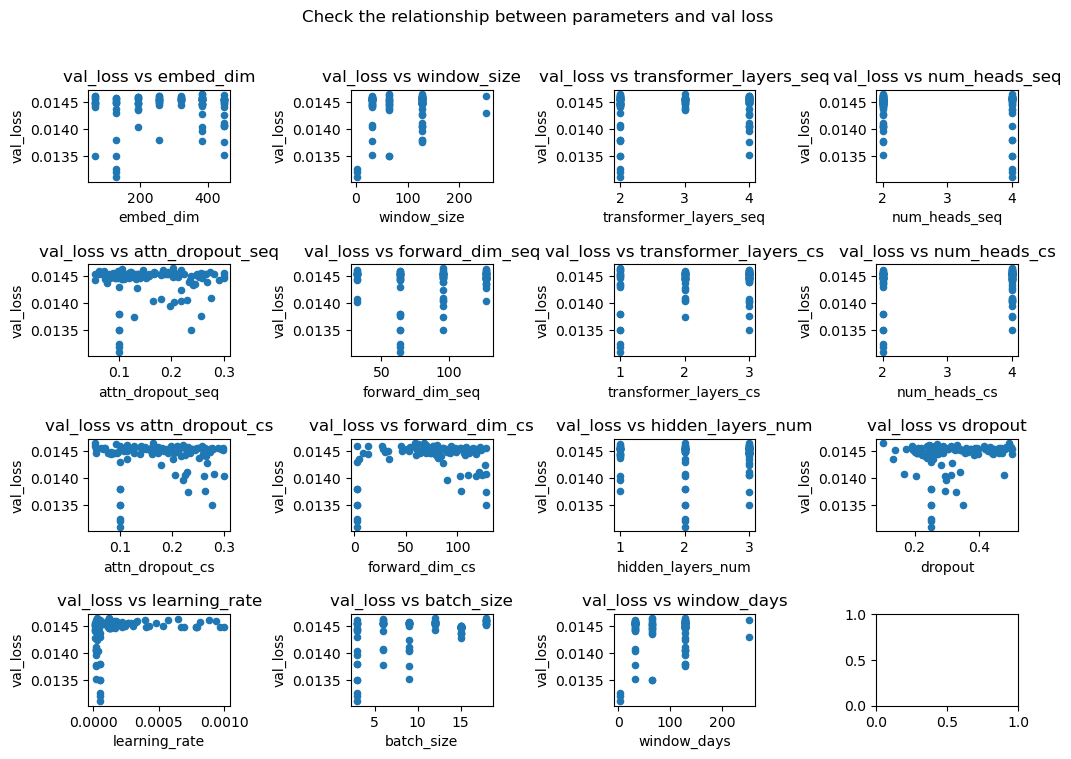

In [ ]:
# Quick analysis
param_feat_df = trial_results.drop(columns=['trial_number','rebal_freq','train_loss','val_loss']) 
# target_loss_df = trail_results['val_loss']

n = len(param_feat_df.columns)
n_per_row=4

# for col in trail_results.drop(columns=['trial_number','train_loss','test_loss']):
                
if n%n_per_row==0:
    n_rows = n//n_per_row
else:
    n_rows = n//n_per_row+1
fig1, ax1 = plt.subplots(n_rows, n_per_row, figsize=(12,8))
for i, col in enumerate(param_feat_df.columns):
    trial_results[[col]+['val_loss']].plot.scatter(x=col,y='val_loss', ax=ax1[i//n_per_row, i%n_per_row])
    ax1[i//n_per_row, i%n_per_row].set_title(f'val_loss vs {col}')
plt.suptitle('Check the relationship between parameters and val loss')
plt.subplots_adjust(hspace=0.9, wspace=0.85)
plt.show()

### Log model train/val loss charts

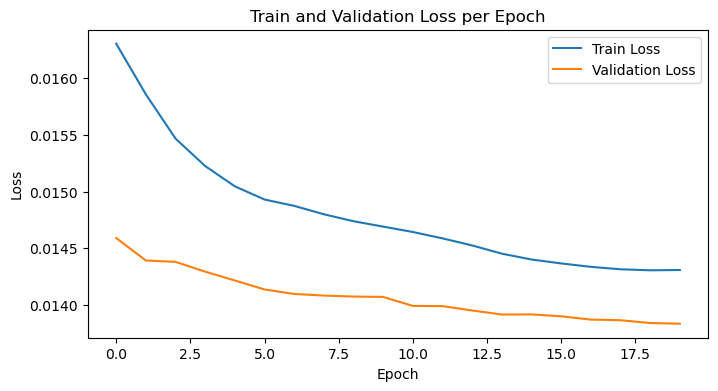

In [ ]:
# Plot train and val loss per epoch - daily 33 (trf square) - tranf square
def plot_train_val_loss(train_loss_l, val_loss_l):
    plt.figure(figsize=(8, 4))
    plt.plot(train_loss_l, label='Train Loss')
    plt.plot(val_loss_l, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss per Epoch')
    plt.legend(loc='upper right')

plot_train_val_loss(train_loss_l, val_loss_l)

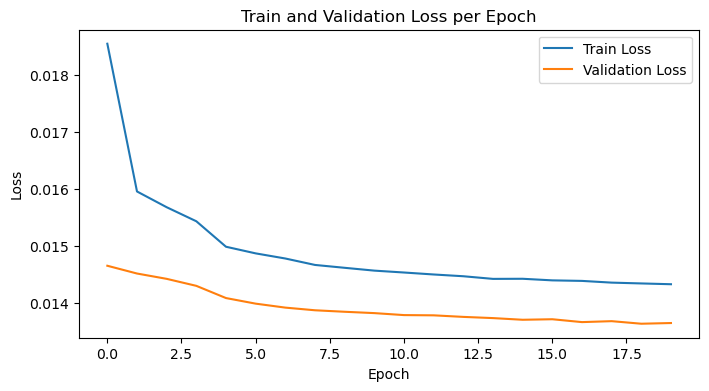

In [ ]:
# Plot train and val loss per epoch - daily 37 (trf square) - tranf square
def plot_train_val_loss(train_loss_l, val_loss_l):
    plt.figure(figsize=(8, 4))
    plt.plot(train_loss_l, label='Train Loss')
    plt.plot(val_loss_l, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss per Epoch')
    plt.legend(loc='upper right')

plot_train_val_loss(train_loss_l, val_loss_l)

### Save / load models

In [ ]:
# prompt: save the model in current directionary with a given name, and recover later

def save_model(model, train_loss_l, val_loss_l, model_dir, model_filename, is_s3):

    module = model.module if hasattr(model, 'module') else model ## ELAINE
    model_item = module.state_dict()  ## ELAINE
    model_save_path = model_dir + model_filename  ## IN for notebook, need version controled model name

    if is_s3:
        ## save the train and val loss results
        with fs.open(model_save_path, 'wb') as f:
            torch.save(model_item, f)
        with fs.open(f'{model_dir}train_loss_l_{model_filename}.pkl', 'wb') as f:
            pickle.dump(train_loss_l, f)
        with fs.open(f'{model_dir}val_loss_l_{model_filename}.pkl', 'wb') as f:
            pickle.dump(val_loss_l, f)
    else:
        ## save the train and val loss results
        torch.save(model_item, model_dir+model_filename)
        with open(f'{model_dir}train_loss_l_{model_filename}.pkl', 'wb') as f:
            pickle.dump(train_loss_l, f)
        with open(f'{model_dir}val_loss_l_{model_filename}.pkl', 'wb') as f:
            pickle.dump(val_loss_l, f)

def load_model(model_dir, model_filename, model_class, is_s3):
    # model = model_class()  #create a new instance with default values (note need to have default values)
    model = model_class  #use a new instance with the same param as the model to be loaded (note need to have default values)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    try:
        print ('Initial try')
        model.load_state_dict(torch.load(model_dir+model_filename,
                                           map_location=device, weights_only=True, strict=False)) # Load model weights
        model.to(device)
    except: 
        print ('Use except handling')
        withprefix_content = torch.load(model_dir + model_filename, 
                                        map_location=device, weights_only=True)
        new_state_dict = {k.replace("module.", ""): v for k, v in withprefix_content.items()}  # Remove "module." prefix
        model.load_state_dict(new_state_dict, strict=False)
        model.to(device)

    if is_s3:
        with fs.open(f'{model_dir}train_loss_l_{model_filename}.pkl', 'rb') as f:
            train_loss_l = pickle.load(f)
    
        with fs.open(f'{model_dir}val_loss_l_{model_filename}.pkl', 'rb') as f:
            val_loss_l = pickle.load(f)
    else:
        with open(f'{model_dir}train_loss_l_{model_filename}.pkl', 'rb') as f:
            train_loss_l = pickle.load(f)
    
        with open(f'{model_dir}val_loss_l_{model_filename}.pkl', 'rb') as f:
            val_loss_l = pickle.load(f)

    return model, train_loss_l, val_loss_l

def load_model_losses(model_dir, model_filename, is_s3):

    if is_s3:
        with fs.open(f'{model_dir}train_loss_l_{model_filename}.pkl', 'rb') as f:
            train_loss_l = pickle.load(f)
    
        with fs.open(f'{model_dir}val_loss_l_{model_filename}.pkl', 'rb') as f:
            val_loss_l = pickle.load(f)
    else:
        with open(f'{model_dir}train_loss_l_{model_filename}.pkl', 'rb') as f:
            train_loss_l = pickle.load(f)
    
        with open(f'{model_dir}val_loss_l_{model_filename}.pkl', 'rb') as f:
            val_loss_l = pickle.load(f)

    return train_loss_l, val_loss_l

In [ ]:
# save model
rebal_freq = 'D'
dl_model_folder_dir ='/home/sagemaker-user/user-default-efs/dl_model/' ## for sm ; folder: 'M', 'W', 'D'
model_filename = 'model_dl_trf_sm_61' # Choose a filename for your model; model_dl_att_sm_1, model_dl_trf_sm_1, model_dl_trf_sm_2

dl_model_directory = f'{dl_model_folder_dir}{dl_model_checkpoint}/{rebal_freq}/'

save_model(model_dl, train_loss_l, val_loss_l, dl_model_directory, model_filename, is_s3=False)

In [ ]:
# load model
# if not already defined:
window_days = 128
# tgt_cols = ['excess_ret'] # 
# tgt_cols = ['excess_ret', 'ret_vol_20d', 'mkt_ret_vol_20d']
tgt_cols = ['excess_ret', 'ret_vol_20d', 'mkt_ret_vol_20d', 'abs_ret', 'next_5d_ret', 'next_5d_abs_ret']
sel_features_adj = ['market_equity_rank',
 'book_to_equity_rank',
 'asset_growth_rank',
 'opt_to_book_eq_rank',
 'ret_12m_d_rank',
 'ret_3m_d_rank',
 'ret_6m_d_rank',
 'ret_1m_d_rank',
 'ret_60_12_rank',
 'scaled_prev_d_exc_ret',
 'scaled_prev_d_mkt_ret',
 'scaled_prev_d_ret_vol_20d',
 'scaled_prev_d_mkt_ret_vol_20d',
 'scaled_senti_score']

feature_cols = sel_features_adj

# # initiate a model with the exact same params
model_dl_trf_sq_load = ReturnPredictionModel_Transformer_square(
    input_dim = len(feature_cols),
    embed_dim = 256,
    window_size = window_days,
    transformer_layers_seq = 2, 
    num_heads_seq = 4,
    attn_dropout_seq = 0.1, 
    forward_dim_seq = 64,
    transformer_layers_cs = 1,
    num_heads_cs = 2,
    attn_dropout_cs = 0.1,
    forward_dim_cs = 3,
    hidden_dims_l = [252, 128],
    dropout = 0.25,
    output_dim = len(tgt_cols)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rebal_freq = 'D'
dl_model_folder_dir = '/home/sagemaker-user/user-default-efs/dl_model/'
dl_model_directory = f'{dl_model_folder_dir}{dl_model_checkpoint}/{rebal_freq}/' ## for sm ; folder: 'M', 'W', 'D'
model_filename = 'model_dl_trf_sm_37'  # Choose a filename for your model; model_dl_att_sm_1, model_dl_trf_sm_1, model_dl_trf_sm_2
model_class = model_dl_trf_sq_load   #IN: if using already initiated instance, this should match the model to be laoded, note that batch size doesn't matter

model_dl, train_loss_l, val_loss_l = load_model(dl_model_directory, model_filename, model_class, is_s3=False)

Initial try
Use except handling


### Make predictions

In [ ]:
%%time
def make_prediction_dual(model, dataloader):
    model.eval()
    pred_l = []
    pred_l_5d = []
    sim_dic = {}
    # print (pred_l)

    with torch.no_grad():
        for batch_idx, batch_item in enumerate(dataloader):
            x_batch, y_batch = \
                batch_item['features'].to(device), \
                    batch_item['target'].to(device)
            pred, stock_emb_matrix = model(x_batch) # stock_emb_matrix should be of dimension of batch_size, stock_num, embed_dim
            # given it's batch by batch and each rebal's 500 stocks may not be the same, so proces one by one
            pred_batch_l = []
            pred_batch_l_5d = []

            for idx in range(len(pred)):
                # process pred_return
                date = pd.Timestamp.fromtimestamp(batch_item['date'][idx].item()).normalize()
                columns_raw = batch_item['permnos'][idx].cpu().numpy().astype(int)
                pred_t = pred[idx].squeeze(-1).cpu().numpy()
                # print (pred_t[:,0][None,:].shape)
                # for next day return
                df_temp = pd.DataFrame(pred_t[None,:] if pred_t.ndim==1 else pred_t[:,0][None,:],
                                      index=[date],
                                      columns = columns_raw)
                df_temp = df_temp.drop(columns=[x for x in df_temp.columns if len(str(x))==1]) # drop the filler columns with column name '1'
                pred_batch_l.append(df_temp)
                # for next 5d return
                df_temp_5d = pd.DataFrame(pred_t[None,:] if pred_t.ndim==1 else pred_t[:,4][None,:],
                                      index=[date],
                                      columns = columns_raw)
                df_temp_5d = df_temp_5d.drop(columns=[x for x in df_temp_5d.columns if len(str(x))==1]) # drop the filler columns with column name '1'
                pred_batch_l_5d.append(df_temp_5d)
                
                # process embedding similarity
                stock_emb_t = stock_emb_matrix[idx].squeeze(-1).cpu().numpy()
                cos_sim = cosine_similarity(stock_emb_t) # should be the same numerically
                # print (cos_sim.shape)
                sim_dic[date] =  pd.DataFrame(cos_sim, index=columns_raw, columns=columns_raw)\
                                .loc[df_temp.columns, df_temp.columns]                                             
            
            # print (pred_batch_l)
            pred_batch_df = pd.concat(pred_batch_l, axis=0)
            pred_batch_df_5d = pd.concat(pred_batch_l_5d, axis=0)
        
            pred_l.append(pred_batch_df)
            pred_l_5d.append(pred_batch_df_5d)
            # print (pred_l)

    pred_df = pd.concat(pred_l, axis=0) # index: dates, col: stock permnos
    pred_df_5d = pd.concat(pred_l_5d, axis=0) # index: dates, col: stock permnos
    sim_df = pd.concat(sim_dic, names =['date'])
    return pred_df, pred_df_5d, sim_df

# if try to record both next day and next 5 day return
pred_rtn_df, pred_rtn_df_5d, sim_df = make_prediction_dual(model_dl, train_val_dataloader_dl) # if predict for train and val
print (pred_rtn_df.shape)
print (pred_rtn_df_5d.shape)
print (sim_df.shape)

pred_rtn_df_test, pred_rtn_df_5d_test, sim_df_test = make_prediction_dual(model_dl, test_dataloader_dl) # if predict for test
print (pred_rtn_df_test.shape)
print (pred_rtn_df_5d_test.shape)
print (sim_df_test.shape)
# note: we can also make a concat trai

(5264, 1008)
(5264, 1008)
(2631848, 1008)
(1005, 571)
(1005, 571)
(502469, 571)
CPU times: user 3h 42min 58s, sys: 6min 42s, total: 3h 49min 40s
Wall time: 7min 26s


#### If to save pred_df:

In [ ]:
with open(f'{dl_model_directory}pred_rtn_df_{model_filename}.pkl', 'wb') as f:
    pickle.dump(pred_rtn_df, f)

with open(f'{dl_model_directory}pred_rtn_df_test_{model_filename}.pkl', 'wb') as f:
    pickle.dump(pred_rtn_df_test, f)

# if 5d return pred are also produced
with open(f'{dl_model_directory}pred_rtn_df_5d_{model_filename}.pkl', 'wb') as f:
    pickle.dump(pred_rtn_df_5d, f)

with open(f'{dl_model_directory}pred_rtn_df_5d_test_{model_filename}.pkl', 'wb') as f:
    pickle.dump(pred_rtn_df_5d_test, f)

#### check pred_df

In [ ]:
# check predicted vs actual returns - weekly
plt.figure(figsize=(6,4))
train_used[['date','permno','excess_ret']].set_index(['date','permno']).unstack().mean(axis=1).plot(label='actual return')
pred_rtn_df.mean(axis=1).plot(label='predicted return')
plt.title('Average return per stock over time')
plt.legend()
plt.show()

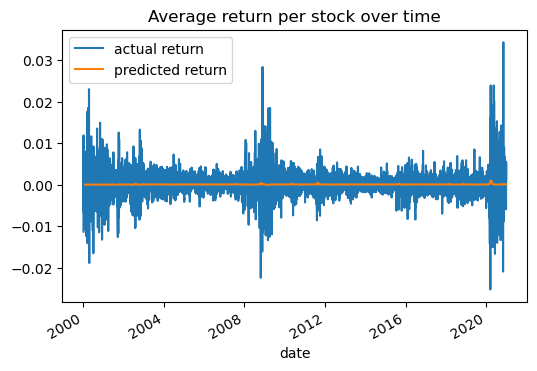

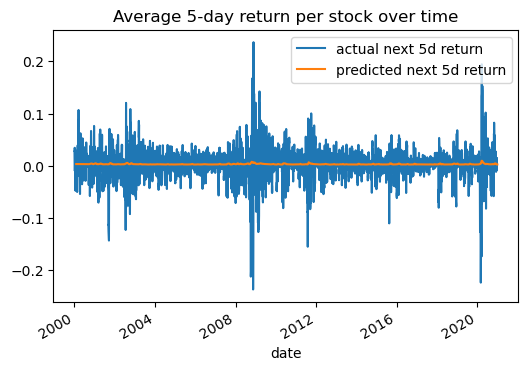

In [ ]:
# check predicted vs actual returns - daily
plt.figure(figsize=(6,4))
# train_used[['date','permno','excess_ret']].set_index(['date','permno']).unstack().mean(axis=1).plot(label='actual return')
train_val_used[['date','permno','excess_ret']].set_index(['date','permno']).unstack().mean(axis=1).plot(label='actual return')
pred_rtn_df.mean(axis=1).plot(label='predicted return')
plt.title('Average return per stock over time')
plt.legend()
plt.show()

# # check next 5day return vs actual - average, daily
plt.figure(figsize=(6,4))
# train_used[['date','permno','excess_ret']].set_index(['date','permno']).unstack().mean(axis=1).plot(label='actual return')
train_val_used[['date','permno','next_5d_ret']].set_index(['date','permno']).unstack().mean(axis=1).plot(label='actual next 5d return')
pred_rtn_df_5d.mean(axis=1).plot(label='predicted next 5d return')
plt.title('Average 5-day return per stock over time')
plt.legend()
plt.show()

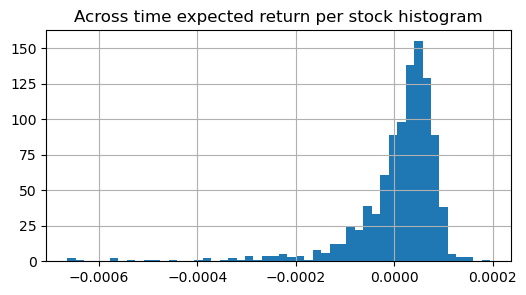

count    1008.00000
mean        0.00001
std         0.00009
min        -0.00066
25%        -0.00001
50%         0.00003
75%         0.00006
max         0.00020
dtype: float64

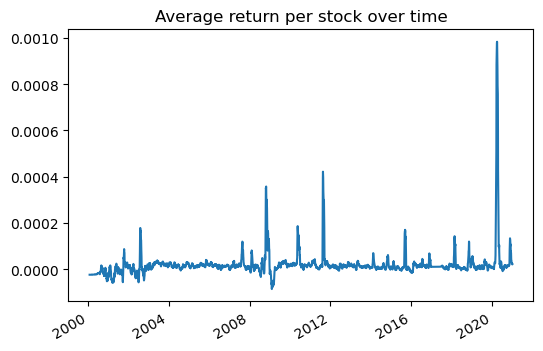

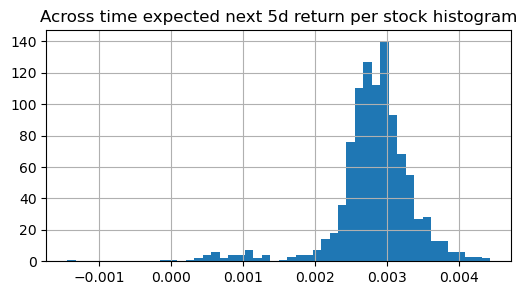

count    1008.00000
mean        0.00282
std         0.00058
min        -0.00144
25%         0.00262
50%         0.00286
75%         0.00311
max         0.00443
dtype: float64

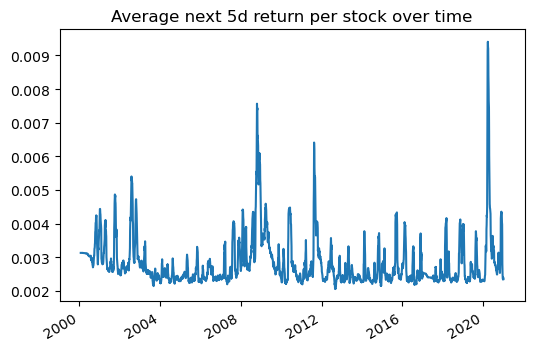

In [ ]:
# checking some results of predicted returns
pred_rtn_df.mean().hist(bins=50, figsize=(6,3))
plt.title('Across time expected return per stock histogram')
plt.show()

display(np.round(pred_rtn_df.mean().describe(),5))

pred_rtn_df.mean(axis=1).plot(title='Average return per stock over time', figsize=(6,4))
plt.show()

## if also check next 5d return pattern
pred_rtn_df_5d.mean().hist(bins=50, figsize=(6,3))
plt.title('Across time expected next 5d return per stock histogram')
plt.show()

display(np.round(pred_rtn_df_5d.mean().describe(),5))

pred_rtn_df_5d.mean(axis=1).plot(title='Average next 5d return per stock over time', figsize=(6,4))
plt.show()

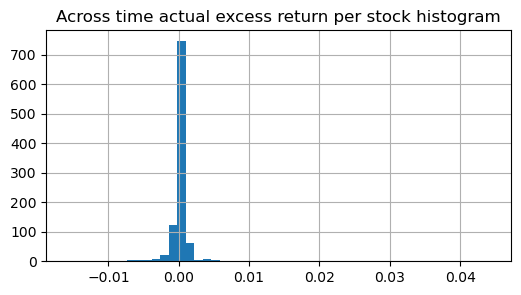

count    913.000000
mean       0.000177
std        0.002092
min       -0.015805
25%        0.000032
50%        0.000293
75%        0.000511
max        0.044269
dtype: float64

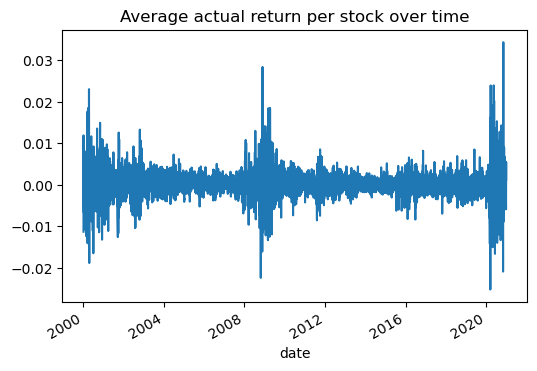

In [ ]:
# checking some results of actual returns
plt.figure(figsize=(6,3))
# train_used[['date','permno','excess_ret']].set_index(['date','permno']).unstack().mean().hist(bins=50)
train_val_used[['date','permno','excess_ret']].set_index(['date','permno']).unstack().mean().hist(bins=50)
plt.title('Across time actual excess return per stock histogram')
plt.show()

display(train_used[['date','permno','excess_ret']].set_index(['date','permno']).unstack().mean().describe())

plt.figure(figsize=(6,4))
# train_used[['date','permno','excess_ret']].set_index(['date','permno']).unstack().mean(axis=1).plot(title='Average actual return per stock over time')
train_val_used[['date','permno','excess_ret']].set_index(['date','permno']).unstack().mean(axis=1).plot(title='Average actual return per stock over time')
plt.show()

## Connect the NN prediction to rolling optimizer

### Perform Optimization

In [ ]:
# if not already exist:
dl_model_directory='/home/sagemaker-user/user-default-efs/dl_model/dl_model_checkpoint0/D/'
model_filename='model_dl_trf_sm_37' #'model_dl_trf_sm_54'

In [ ]:
# if to load pred_rtn_df from drive
display(dl_model_directory)
display(model_filename)

with open(f'{dl_model_directory}pred_rtn_df_{model_filename}.pkl', 'rb') as f:
    pred_rtn_df = pickle.load(f)

with open(f'{dl_model_directory}pred_rtn_df_test_{model_filename}.pkl', 'rb') as f:
    pred_rtn_df_test = pickle.load(f)

'/home/sagemaker-user/user-default-efs/dl_model/dl_model_checkpoint0/D/'

'model_dl_trf_sm_37'

In [ ]:
%%time
n_multiple = 252 # (fixed) for annualization
opt_window = batch_size  # batch_size, window_days
# opt_dataset = train_val_dataset_dl  # train_dataset_dl or train_val_dataset_dl, or ConcatDataset([train_val_dataset_dl, test_dataset_dl])
opt_dataset = ConcatDataset([train_val_dataset_dl, test_dataset_dl])  # train_dataset_dl or train_val_dataset_dl, or ConcatDataset([train_val_dataset_dl, test_dataset_dl])
# opt_date_data_used = train_val_used # train_val_used, or pd.concat([train_val_used, test_used])
opt_date_data_used = pd.concat([train_val_used, test_used]) # train_val_used, or pd.concat([train_val_used, test_used])
rebal_freq = 'D' # IN: 'D', 'W', 'M'
opt_flag = 'max_sharpe'  #IN: 'target_risk' or 'max_sharpe'
target_risk = 0.2  #IN: this is an example of 20% annual portfolio risk
rebal_dates = [pd.Timestamp.fromtimestamp(item['date'].item()).normalize() for item in opt_dataset] # or train_dataset_dl.dates will do in this case, but wont work for concat datasets
dates_daily = opt_date_data_used['date'].unique()[20:] # or train_dataset_dl.dates_daily or train_val_used['date'].unique()[20:] for concat train_val situation
# pred_rtn_df_opt = pred_rtn_df  # pred_rtn_df, pred_rtn_df_5d, or pd.concat([pred_rtn_df, pred_rtn_df_test])
pred_rtn_df_opt = pd.concat([pred_rtn_df, pred_rtn_df_test])  # pred_rtn_df, pred_rtn_df_5d, or pd.concat([pred_rtn_df, pred_rtn_df_test])
# rolling_ana_data_used = train_val_used # train_val_used, or pd.concat([train_val_used, test_used])
rolling_ana_data_used = pd.concat([train_val_used, test_used]) # train_val_used, or pd.concat([train_val_used, test_used])
# window_days= window_days

def opt_t(date, pred_rtn_df, opt_window, dates_daily, rolling_ana_data_used, opt_flag, target_risk, rebal_freq, n_multiple, sim_df=None):
    '''get the rolling period data'''
    index_in_daily_dates = list(dates_daily).index(dates_daily[dates_daily<=date][-1])

    date_period = dates_daily[max(0,(index_in_daily_dates+1)-opt_window*1)
                                :max(opt_window*1, (index_in_daily_dates+1))]
    data_t = rolling_ana_data_used[rolling_ana_data_used['date'].isin(date_period)]

    '''find the appropriate target date in tradeable days'''
    if rebal_freq == 'M':
        match_date = dates_daily[(dates_daily.month==date.month)
                                       &(dates_daily.year==date.year)][-1]
    elif rebal_freq == 'W':
        match_date = dates_daily[(dates_daily<=date)][-1]
    else:
        match_date = date

    ''' optimization'''
    # get the exp return for stocks at rebal date
    temp_rtn = pred_rtn_df_opt.loc[match_date,:]
    exp_exc_rtn_t = temp_rtn.where([len(str(x))==5 for x in temp_rtn.index], np.nan).dropna().to_frame().T

    try:
        return_data = data_t[['date','permno']+['prev_d_exc_ret']]\
            .groupby(['date','permno'])['prev_d_exc_ret'].last().unstack()[exp_exc_rtn_t.columns].replace(np.nan, 0)
    except KeyError:
        print ('adjust columns')
        intersect_cols= list(set(data_t['permno'].unique()).intersection(set(exp_exc_rtn_t.columns.tolist())))
        return_data = data_t[['date','permno']+['prev_d_exc_ret']]\
            .groupby(['date','permno'])['prev_d_exc_ret'].last().unstack()[intersect_cols].replace(np.nan, 0)
        exp_exc_rtn_t = exp_exc_rtn_t[intersect_cols]
                         
    if sim_df is None:
        p = LedoitWolf().fit(return_data).covariance_
        p += np.eye(p.shape[0])*1e-8 # add small number to incerase numerical stability
        cov_matrix = risk_models.fix_nonpositive_semidefinite(
            pd.DataFrame(p,
                     index=return_data.columns, columns=return_data.columns)*n_multiple, fix_method='spectral')
        # fix_method: {"spectral", "diag"}, defaults to "spectral"
    else: 
        sim_t = sim_df.loc[match_date] 
        sim_t = sim_t[sim_t.index] #only obtain the stocks exists that day
        coeff_matrix = np.array(sim_t)
        
        vol = np.array(return_data.std()) 
        # print (vol.shape) 
        vol_matrix = np.diag(vol) 

        p = vol_matrix @ coeff_matrix @ vol_matrix
        p += np.eye(p.shape[0])*1e-8 # add small number to incerase numerical stability
        cov_matrix = risk_models.fix_nonpositive_semidefinite(
            pd.DataFrame(p,
                     index=return_data.columns, columns=return_data.columns)*n_multiple, fix_method='spectral')
    
    opt_w_ef = optimizer_ef(exp_exc_rtn_t.squeeze()*n_multiple, cov_matrix, opt_flag, target_risk,
                 solver_name='CLARABEL', market_neutral=False, risk_free_rate=None)  
    # IN: if has value error complaining exp return all below risk free rate, could set risk free rate to zero here
    #IN: note the optimizer requires the expected return being series/array
    opt_w_t = pd.DataFrame(opt_w_ef, index=[date])

    return exp_exc_rtn_t, opt_w_t

# Run in parallel
## IN: note the results from the parallel processing has to be just one list of result
# at each t, which could be a tuple of different results at each time t
# sim_df = sim_df # sim_df or None

res_list = Parallel(n_jobs=-1)(delayed(
    opt_t)(date, pred_rtn_df, opt_window, dates_daily, rolling_ana_data_used, opt_flag, target_risk, rebal_freq, n_multiple, sim_df=None)
    for date in rebal_dates
)

# Organize the results
exp_exc_rtn_df = pd.concat([res_t[0] for res_t in res_list])
opt_weight_df = pd.concat([res_t[1] for res_t in res_list])

CPU times: user 8min 46s, sys: 2min 54s, total: 11min 41s
Wall time: 12min 47s


### If Apply Senti Score As Scaler to Adjust Opt Weights

<Axes: >

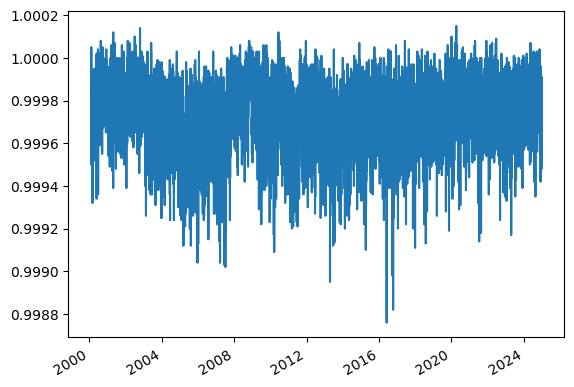

In [ ]:
opt_weight_df_0 = opt_weight_df.copy()
opt_weight_df_0.sum(axis=1).plot()

<Axes: >

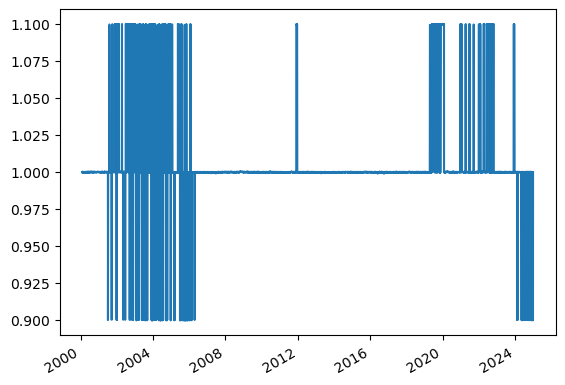

In [ ]:
rolling_ana_data_used = pd.concat([train_val_used, test_used])

senti_score_used = rolling_ana_data_used[['date','senti_score']].set_index('date').drop_duplicates()\
        .reindex(opt_weight_df.index)


senti_scale = senti_score_used['senti_score'].ewm(com=2).mean().apply(lambda x: 1.1 if x>0.6 else 0.9 if x<0.4 else 1)

opt_weight_df = opt_weight_df_0.mul(senti_scale, axis=0)

# check:
opt_weight_df.sum(axis=1).plot()

In [ ]:
opt_weight_df.tail()

,10078,10104,10107,10138,10145,10147,10225,10353,10401,10516,...,18726,25146,18267,19788,82486,25434,20391,12591,13628,87034
2024-12-24,NaN,0.0,0.003123,0.000000,0.001188,NaN,NaN,NaN,NaN,0.000486,...,0.0,0.000000,0.00000,0.0,0.0,NaN,0.0,0.002547,0.000000,0.001350
2024-12-26,NaN,0.0,0.003744,0.000000,0.001215,NaN,NaN,NaN,NaN,0.000000,...,0.0,0.000000,0.00000,0.0,0.0,NaN,0.0,0.005364,0.000000,0.004338
2024-12-27,NaN,0.0,0.003501,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000819,...,0.0,0.005004,0.00000,0.0,0.0,NaN,0.0,0.005526,0.000000,0.004077
2024-12-30,NaN,0.0,0.006426,0.004311,0.001557,NaN,NaN,NaN,NaN,0.000000,...,0.0,0.000000,0.00000,0.0,0.0,NaN,0.0,0.009459,0.000252,0.005013
2024-12-31,NaN,0.0,0.004620,0.004190,0.003760,NaN,NaN,NaN,NaN,0.000330,...,0.0,0.000000,0.00096,0.0,0.0,NaN,0.0,0.003180,0.000000,0.004570


### Save / Load Portf Weights

In [ ]:
## If to save the opt weights
dl_model_directory='/home/sagemaker-user/user-default-efs/dl_model/dl_model_checkpoint0/D/'
model_filename='model_dl_trf_sm_54'

In [ ]:
## If to save the opt weights
display(dl_model_directory)
display(model_filename)

try:
    with open(f'{dl_model_directory}opt_weight_df_0_{model_filename}.pkl', 'wb') as f:
        pickle.dump(opt_weight_df_0, f)
except:
    print ('no opt_weight_df_0 here')
    pass


with open(f'{dl_model_directory}opt_weight_df_{model_filename}.pkl', 'wb') as f:
    pickle.dump(opt_weight_df, f)

with open(f'{dl_model_directory}exp_exc_rtn_df_{model_filename}.pkl', 'wb') as f:
    pickle.dump(exp_exc_rtn_df, f)

'/home/sagemaker-user/user-default-efs/dl_model/dl_model_checkpoint0/D/'

'model_dl_trf_sm_54'

no opt_weight_df_0 here


In [ ]:
## if to load opt weights from saved model results
# if not already exist:
dl_model_directory='/home/sagemaker-user/user-default-efs/dl_model/dl_model_checkpoint0/D/'
model_filename='model_dl_trf_sm_56'

In [ ]:
# if to load opt weights from saved model results

display(dl_model_directory)
display(model_filename)

try:
    with open(f'{dl_model_directory}opt_weight_df_0_{model_filename}.pkl', 'rb') as f:
        opt_weight_df_0 = pickle.load(f)
except:
    print ('no opt_weight_df_0 was saved')
    pass


with open(f'{dl_model_directory}opt_weight_df_{model_filename}.pkl', 'rb') as f:
    opt_weight_df = pickle.load(f)

with open(f'{dl_model_directory}exp_exc_rtn_df_{model_filename}.pkl', 'rb') as f:
    exp_exc_rtn_df = pickle.load(f)

#### Check opt weights

In [ ]:
opt_weight_df.iloc[20:,:]

,10078,10104,10107,10138,10145,10147,10225,10353,10401,10516,...,18726,25146,18267,19788,82486,25434,20391,12591,13628,87034
2000-03-01,0.0,0.0,0.000430,0.000000,0.000000,0.0,0.0,0.0,0.00196,0.000590,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-02,0.0,0.0,0.000660,0.000000,0.000000,0.0,0.0,0.0,0.00116,0.001200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-03,0.0,0.0,0.000870,0.000000,0.000180,0.0,0.0,0.0,0.00055,0.001050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-06,0.0,0.0,0.001110,0.000000,0.000130,0.0,0.0,0.0,0.00069,0.001020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-07,0.0,0.0,0.001000,0.000000,0.000170,0.0,0.0,0.0,0.00053,0.001000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,NaN,0.0,0.003123,0.000000,0.001188,NaN,NaN,NaN,NaN,0.000486,...,0.0,0.000000,0.00000,0.0,0.0,NaN,0.0,0.002547,0.000000,0.001350
2024-12-26,NaN,0.0,0.003744,0.000000,0.001215,NaN,NaN,NaN,NaN,0.000000,...,0.0,0.000000,0.00000,0.0,0.0,NaN,0.0,0.005364,0.000000,0.004338
2024-12-27,NaN,0.0,0.003501,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000819,...,0.0,0.005004,0.00000,0.0,0.0,NaN,0.0,0.005526,0.000000,0.004077
2024-12-30,NaN,0.0,0.006426,0.004311,0.001557,NaN,NaN,NaN,NaN,0.000000,...,0.0,0.000000,0.00000,0.0,0.0,NaN,0.0,0.009459,0.000252,0.005013


## Check weights properties and portfolio performance

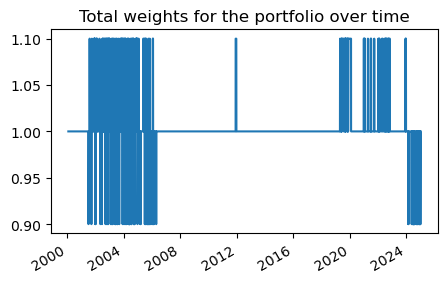

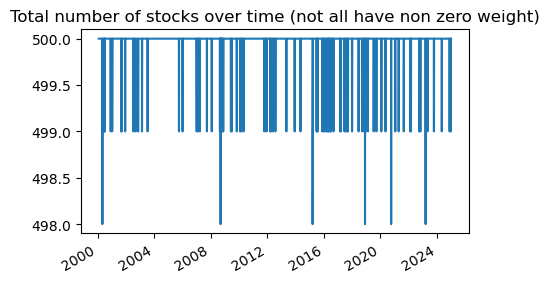

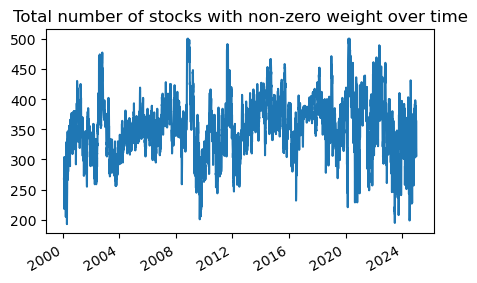

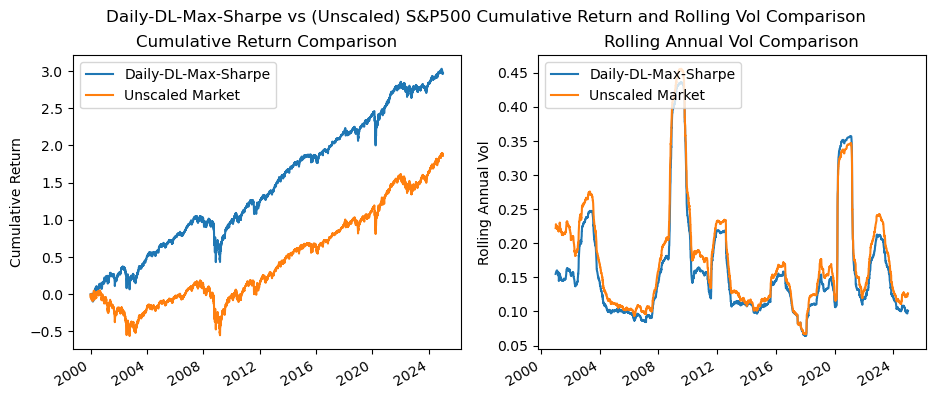

             Daily-DL-Max-Sharpe Unscaled Market
avg_rtn_ann             0.118898        0.074665
vol_ann                 0.176471        0.193884
sharpe_ann               0.67375        0.385098
max_drawdown           -0.510219       -0.567754


In [ ]:
# check basic properties for optimization weights - daily:
check_weights_plots(opt_weight_df)

# with further revised perf function - including test
portf_rtn, portf_mkt_rtn, stats_df, scaler_df, fig_perf = \
    portfolio_performance(pd.concat([train_val_used, test_used]), opt_weight_df, 'Daily-DL-Max-Sharpe', 'D', pd.concat([train_val_mkt, test_mkt]), \
                          last_win_only=False, vol_scaler_flag=False, scaling_vol_tgt=0.3, plot_show=True)

# # with further revised perf function - just test
# portf_rtn, portf_mkt_rtn, stats_df, scaler_df, fig_perf = \
#     portfolio_performance(test_used, opt_weight_df.loc['2021-01-01':,:].dropna(how='all', axis=1), 'Daily-DL-Max-Sharpe', 'D', test_mkt, \
#                           last_win_only=False, vol_scaler_flag=False, scaling_vol_tgt=0.3, plot_show=True)

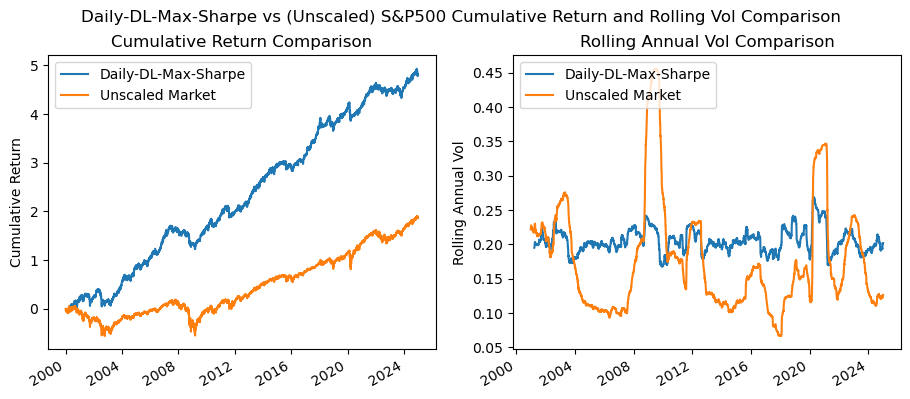

             Daily-DL-Max-Sharpe Unscaled Market
avg_rtn_ann             0.193873        0.074665
vol_ann                 0.205485        0.193884
sharpe_ann              0.943488        0.385098
max_drawdown           -0.409979       -0.567754


In [ ]:
# With constant vol scaler

portf_rtn, portf_mkt_rtn, stats_df, scaler_df, fig_perf = \
    portfolio_performance(pd.concat([train_val_used, test_used]), opt_weight_df, 'Daily-DL-Max-Sharpe', 'D', pd.concat([train_val_mkt, test_mkt]), \
                          last_win_only=False, vol_scaler_flag=True, scaling_vol_tgt=0.2, plot_show=True)

# # with further revised perf function - just test
# portf_rtn, portf_mkt_rtn, stats_df, scaler_df, fig_perf = \
#     portfolio_performance(test_used, opt_weight_df.loc['2021-01-01':,:].dropna(how='all', axis=1), 'Daily-DL-Max-Sharpe', 'D', test_mkt, \
#                           last_win_only=False, vol_scaler_flag=True, scaling_vol_tgt=0.2, plot_show=True)

### Save / Load Ultimate Model-Backtest Output

In [ ]:
# save and load model outupt (selective)
def save_model_output(model_output_dic, output_dir, model_filename, is_s3):

    if is_s3:
        with fs.open(f'{output_dir}model_output_dic_{model_filename}.pkl', 'wb') as f:
            pickle.dump(model_output_dic, f)

    else:
        with open(f'{output_dir}model_output_dic_{model_filename}.pkl', 'wb') as f:
            pickle.dump(model_output_dic, f)



def load_model_output(output_dir, model_filename, is_s3):

    if is_s3:
        with fs.open(f'{output_dir}model_output_dic_{model_filename}.pkl', 'rb') as f:
            model_output_dic = pickle.load(f)
  
    else:
        with open(f'{output_dir}model_output_dic_{model_filename}.pkl', 'rb') as f:
            model_output_dic = pickle.load(f)


    return model_output_dic


In [ ]:
# save
# make output_dic
model_output_dic = {
    'portf_rtn':portf_rtn,
    'portf_mkt_rtn': portf_mkt_rtn,
    'stats_df': stats_df,
    'scaler_df': scaler_df,
    'fig_perf': fig_perf,
    'scaled_weight_df': opt_weight_df.multiply(scaler_df, axis=0),
    'opt_weight_df': opt_weight_df,
    'exp_exc_rtn_df': exp_exc_rtn_df,
    # 'sim_df':sim_df
}

rebal_freq = 'D'

output_checkpoint = 'dl_model_output_checkpoint0'
output_dir =f'/home/sagemaker-user/user-default-efs/dl_model/{output_checkpoint}/{rebal_freq}/' ## for sm ; folder: 'M', 'W', 'D'
model_filename = 'model_dl_trf_sm_54' # Choose a filename for your model; model_dl_att_sm_1, model_dl_trf_sm_1, model_dl_trf_sm_2


save_model_output(model_output_dic, output_dir, model_filename, is_s3=False)

## Compare Benchmark, ML and Mkt performance

In [ ]:
# load output -wo senti
rebal_freq = 'D'

output_checkpoint = 'dl_model_output_checkpoint0'
output_dir =f'/home/sagemaker-user/user-default-efs/dl_model/{output_checkpoint}/{rebal_freq}/' ## for sm ; folder: 'M', 'W', 'D'
model_filename_wo_senti = 'model_dl_trf_sm_33' # Choose a filename for your model; model_dl_att_sm_1, model_dl_trf_sm_1, model_dl_trf_sm_2


model_output_dic_wo_senti = load_model_output(output_dir, model_filename_wo_senti, is_s3=False)

In [ ]:
# load output -w senti
rebal_freq = 'D'

output_checkpoint = 'dl_model_output_checkpoint0'
output_dir =f'/home/sagemaker-user/user-default-efs/dl_model/{output_checkpoint}/{rebal_freq}/' ## for sm ; folder: 'M', 'W', 'D'
model_filename_w_senti = 'model_dl_trf_sm_37' # Choose a filename for your model; model_dl_att_sm_1, model_dl_trf_sm_1, model_dl_trf_sm_2

model_output_dic_w_senti = load_model_output(output_dir, model_filename_w_senti, is_s3=False)

In [ ]:
# get benchmark model results
rebal_freq = 'D'
output_checkpoint = 'dl_model_output_checkpoint0'
output_dir =f'/home/sagemaker-user/user-default-efs/dl_model/{output_checkpoint}/{rebal_freq}/' ## for sm ; folder: 'M', 'W', 'D'
# model_filename = 'model_dl_trf_sm_33' # Choose a filename for your model; model_dl_att_sm_1, model_dl_trf_sm_1, model_dl_trf_sm_2
bm_model_filename = 'bm_res_dic_comb' # 'bm_res_dic_train', 'bm_res_dic_test', 'bm_res_dic_comb'

with open(f'{output_dir}{bm_model_filename}.pkl', 'rb') as f:
    bm_res_dic_used = pickle.load(f)

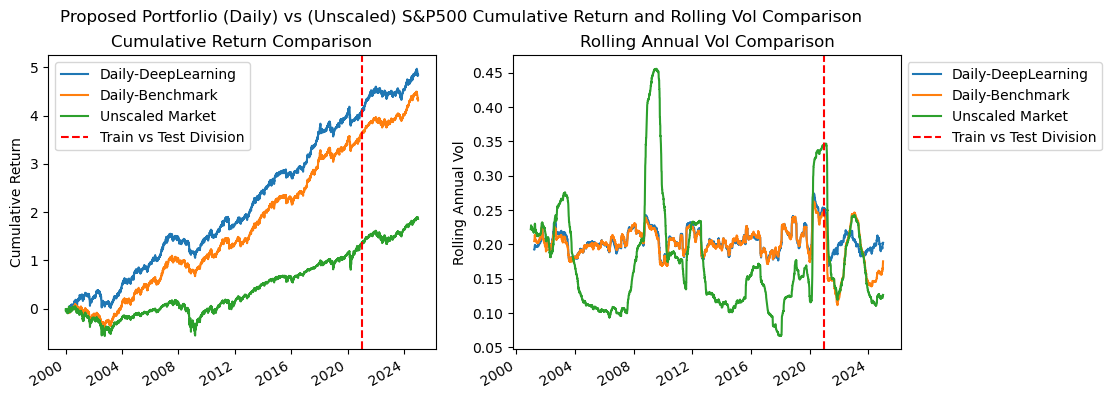

             Daily-DL-Max-Sharpe Daily-Benchmark Unscaled Market
avg_rtn_ann             0.195387        0.174167        0.074665
vol_ann                 0.205625        0.201538        0.193884
sharpe_ann              0.950213        0.864193        0.385098
max_drawdown           -0.418583        -0.42506       -0.567754


In [ ]:
# DL without senti vs bm, mkt
rebal_freq_plot = 'Daily' if rebal_freq == 'D' else 'Weekly' if rebal_freq == 'W' else 'Monthly'
opt_flag_plot = 'Max_Sharpe'

ml_portf_name = f'{rebal_freq_plot}-DeepLearning'
bm_portf_name = f'{rebal_freq_plot}-Benchmark'

portf_rtn_df_l, mkt_rtn = [model_output_dic_wo_senti['portf_rtn'].rename(ml_portf_name), 
                           bm_res_dic_used['portf_rtn'].rename(bm_portf_name)], \
                                model_output_dic_wo_senti['portf_mkt_rtn']['Unscaled Market']
stats_df_l = [model_output_dic_wo_senti['stats_df'], bm_res_dic_used['stats_df'].drop(columns=['Unscaled Market'])]
# rebal_freq = 'D' 

portf_mkt_rtn_comb, stats_df_comb, fig_perf_comb = performance_comparison_all(portf_rtn_df_l, mkt_rtn, stats_df_l, \
        rebal_freq=rebal_freq_plot, last_win_only=False, plot_show=True)

In [ ]:
stats_df_comb

,Daily-DL-Max-Sharpe,Daily-Benchmark,Unscaled Market
avg_rtn_ann,0.195387,0.174167,0.074665
vol_ann,0.205625,0.201538,0.193884
sharpe_ann,0.950213,0.864193,0.385098
max_drawdown,-0.418583,-0.42506,-0.567754


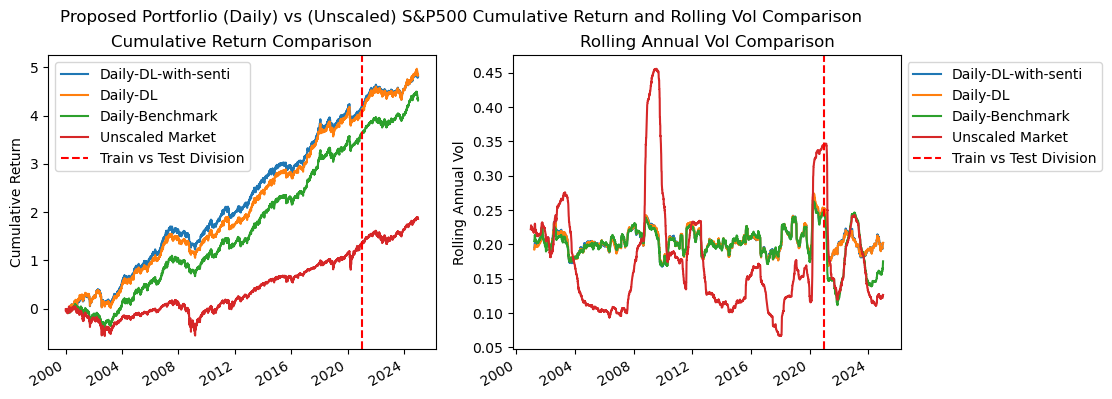

             Daily-DL-Max-Sharpe Daily-DL-Max-Sharpe w senti Daily-Benchmark  \
avg_rtn_ann             0.195387                    0.193873        0.174167   
vol_ann                 0.205625                    0.205485        0.201538   
sharpe_ann              0.950213                    0.943488        0.864193   
max_drawdown           -0.418583                   -0.409979        -0.42506   

             Unscaled Market  
avg_rtn_ann         0.074665  
vol_ann             0.193884  
sharpe_ann          0.385098  
max_drawdown       -0.567754  


In [ ]:
# DL with senti vs DL without senti vs bm, mkt - model new (37 with two senti incorporation) vs model 33
rebal_freq_plot = 'Daily' if rebal_freq == 'D' else 'Weekly' if rebal_freq == 'W' else 'Monthly'
opt_flag_plot = 'Max_Sharpe'
ml_portf_wo_senti_name = f'{rebal_freq_plot}-DL'
ml_portf_w_senti_name = f'{rebal_freq_plot}-DL-with-senti'

# bm_portf_name = f'{rebal_freq_plot}-Benchmark-{opt_flag_plot}'
bm_portf_name = f'{rebal_freq_plot}-Benchmark'

portf_rtn_df_l, mkt_rtn = [model_output_dic_w_senti['portf_rtn'].rename(ml_portf_w_senti_name), 
                           model_output_dic_wo_senti['portf_rtn'].rename(ml_portf_wo_senti_name),
                           bm_res_dic_used['portf_rtn'].rename(bm_portf_name)], \
                                model_output_dic_w_senti['portf_mkt_rtn']['Unscaled Market']

stats_df_wo_mkt = model_output_dic_w_senti['stats_df'].drop(columns=['Unscaled Market'])

stats_df_l = [stats_df_wo_mkt.rename(columns=dict(zip(stats_df_wo_mkt.columns.tolist(),\
                                                  [x+' w senti' for x in stats_df_wo_mkt.columns.tolist()]))),
              model_output_dic_wo_senti['stats_df'],
              bm_res_dic_used['stats_df']]
# rebal_freq = 'D' 

portf_mkt_rtn_comb, stats_df_comb, fig_perf_comb = performance_comparison_all(portf_rtn_df_l, mkt_rtn, stats_df_l, \
        rebal_freq=rebal_freq_plot, last_win_only=False, plot_show=True)

In [ ]:
stats_df_comb

,Daily-DL-Max-Sharpe,Daily-DL-Max-Sharpe w senti,Daily-Benchmark,Unscaled Market
avg_rtn_ann,0.195387,0.193873,0.174167,0.074665
vol_ann,0.205625,0.205485,0.201538,0.193884
sharpe_ann,0.950213,0.943488,0.864193,0.385098
max_drawdown,-0.418583,-0.409979,-0.42506,-0.567754


### Save the full universe full sample comparison results for record keeping purpose

In [ ]:
rebal_freq = 'D'
output_checkpoint = 'dl_model_output_checkpoint0'
output_dir =f'/home/sagemaker-user/user-default-efs/dl_model/{output_checkpoint}/{rebal_freq}/' ## for sm ; folder: 'M', 'W', 'D'

comb_model_output_dic = {
    'portf_mkt_rtn':portf_mkt_rtn_comb,
    'stats_df': stats_df_comb,
    'fig_perf': fig_perf_comb,
}

with open(f'{output_dir}comb_model_output_dic.pkl', 'wb') as f:
    pickle.dump(comb_model_output_dic, f)